GRIDWORLD ENVIRONMENT TEST

Grid size: 3 x 4
Start state: (1, 1)
Goal state: (4, 3) (reward: +1.0)
Trap state: (4, 2) (reward: -1.0)
Wall state: (2, 2)
Step cost: -0.04

Actions: 0=Up, 1=Right, 2=Down, 3=Left


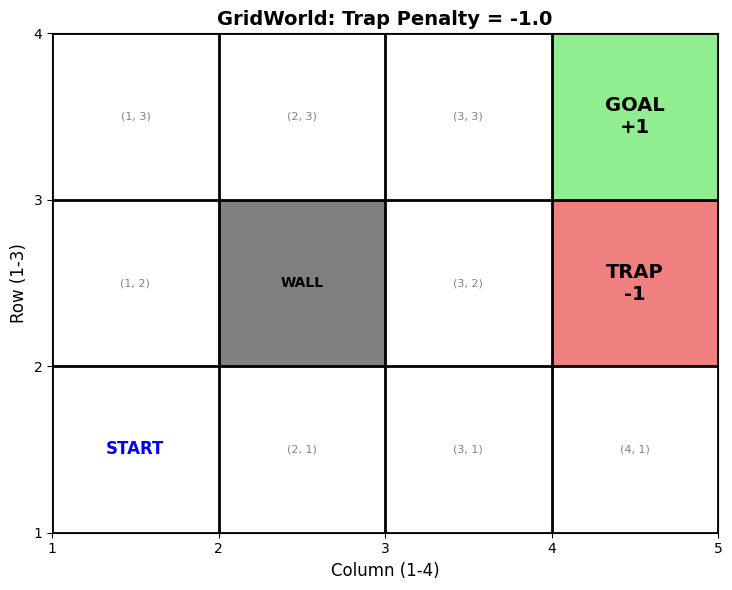

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Define the gridworld environment
class GridWorld:
    def __init__(self, trap_penalty=-1.0):
        """
        GridWorld environment with configurable trap penalty
        
        Parameters:
        -----------
        trap_penalty : float
            Penalty for entering trap state (default: -1.0)
            Can be changed to test different scenarios (e.g., -200.0)
        """
        # Grid layout (1-indexed, col and row start from 1):
        # Row 3 (top):    [(1,3), (2,3), (3,3), (4,3)=GOAL]
        # Row 2:          [(1,2), (2,2)=WALL, (3,2), (4,2)=TRAP]  
        # Row 1 (bottom): [(1,1)=START, (2,1), (3,1), (4,1)]
        
        # Using (col, row) format, 1-indexed
        self.rows = 3
        self.cols = 4
        
        # Special positions (col, row) - 1-indexed
        self.start_state = (1, 1)  # Bottom-left
        self.goal_state = (4, 3)   # Top-right (+1)
        self.trap_state = (4, 2)   # Middle-right (configurable penalty)
        self.wall_state = (2, 2)   # Blocked cell
        
        # Rewards
        self.step_cost = -0.04
        self.goal_reward = 1.0
        self.trap_reward = trap_penalty  # Configurable!
        
        # Current state
        self.state = self.start_state
        
        # Actions: 0=Up, 1=Right, 2=Down, 3=Left
        self.actions = [0, 1, 2, 3]
        self.action_names = ['Up', 'Right', 'Down', 'Left']
        
        # Transition probabilities
        self.intended_prob = 0.8
        self.perpendicular_prob = 0.1
    
    def reset(self):
        """Reset environment to start state"""
        self.state = self.start_state
        return self.state
    
    def is_terminal(self, state):
        """Check if state is terminal (goal or trap)"""
        return state == self.goal_state or state == self.trap_state
    
    def is_valid_state(self, state):
        """Check if state is valid (within bounds and not wall)"""
        col, row = state
        # Check bounds (1-indexed: col 1-4, row 1-3)
        if col < 1 or col > self.cols or row < 1 or row > self.rows:
            return False
        if state == self.wall_state:
            return False
        return True
    
    def get_next_state(self, state, action):
        """Get next state given current state and action (deterministic)"""
        col, row = state
        
        # Action effects: 0=Up, 1=Right, 2=Down, 3=Left
        if action == 0:  # Up (increase row)
            next_state = (col, row + 1)
        elif action == 1:  # Right (increase col)
            next_state = (col + 1, row)
        elif action == 2:  # Down (decrease row)
            next_state = (col, row - 1)
        elif action == 3:  # Left (decrease col)
            next_state = (col - 1, row)
        else:
            next_state = state
        
        # If next state is invalid (wall or out of bounds), stay in current state
        if not self.is_valid_state(next_state):
            return state
        
        return next_state
    
    def get_reward(self, state):
        """Get reward for being in a state"""
        if state == self.goal_state:
            return self.goal_reward
        elif state == self.trap_state:
            return self.trap_reward
        else:
            return self.step_cost
    
    def step(self, action):
        """
        Execute action with stochastic transitions
        80% intended direction, 10% perpendicular left, 10% perpendicular right
        """
        if self.is_terminal(self.state):
            return self.state, 0, True
        
        # Determine actual action taken (with stochasticity)
        rand = random.random()
        
        if rand < self.intended_prob:  # 80% - intended direction
            actual_action = action
        elif rand < self.intended_prob + self.perpendicular_prob:  # 10% - perpendicular left
            # Perpendicular left: Up->Left, Right->Up, Down->Right, Left->Down
            actual_action = (action + 3) % 4
        else:  # 10% - perpendicular right
            # Perpendicular right: Up->Right, Right->Down, Down->Left, Left->Up
            actual_action = (action + 1) % 4
        
        # Get next state
        next_state = self.get_next_state(self.state, actual_action)
        reward = self.get_reward(next_state)
        done = self.is_terminal(next_state)
        
        self.state = next_state
        return next_state, reward, done
    
    def get_all_states(self):
        """Get all valid non-terminal states"""
        states = []
        for row in range(1, self.rows + 1):
            for col in range(1, self.cols + 1):
                state = (col, row)
                if self.is_valid_state(state) and not self.is_terminal(state):
                    states.append(state)
        return states
    
    def visualize_grid(self):
        """Visualize the gridworld"""
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Draw grid
        for i in range(self.rows + 1):
            ax.axhline(i, color='black', linewidth=2)
        for j in range(self.cols + 1):
            ax.axvline(j, color='black', linewidth=2)
        
        # Fill cells (convert 1-indexed to 0-indexed for plotting)
        for row in range(1, self.rows + 1):
            for col in range(1, self.cols + 1):
                state = (col, row)
                # For plotting: subtract 1 from col
                # For row: row 1 should be at bottom (y=0), row 3 at top (y=2)
                plot_col = col - 1
                plot_row = row - 1  # Now row 1 -> 0, row 2 -> 1, row 3 -> 2
                
                if state == self.wall_state:
                    ax.add_patch(plt.Rectangle((plot_col, plot_row), 1, 1, color='gray'))
                    ax.text(plot_col + 0.5, plot_row + 0.5, 'WALL', ha='center', va='center', 
                           fontsize=10, fontweight='bold')
                elif state == self.goal_state:
                    ax.add_patch(plt.Rectangle((plot_col, plot_row), 1, 1, color='lightgreen'))
                    ax.text(plot_col + 0.5, plot_row + 0.5, 'GOAL\n+1', ha='center', va='center', 
                           fontsize=14, fontweight='bold')
                elif state == self.trap_state:
                    ax.add_patch(plt.Rectangle((plot_col, plot_row), 1, 1, color='lightcoral'))
                    penalty_text = f'{self.trap_reward:.0f}' if self.trap_reward != -1 else '-1'
                    ax.text(plot_col + 0.5, plot_row + 0.5, f'TRAP\n{penalty_text}', ha='center', va='center', 
                           fontsize=14, fontweight='bold')
                elif state == self.start_state:
                    ax.text(plot_col + 0.5, plot_row + 0.5, 'START', ha='center', va='center', 
                           fontsize=12, fontweight='bold', color='blue')
                else:
                    ax.text(plot_col + 0.5, plot_row + 0.5, f'{state}', ha='center', va='center', 
                           fontsize=8, color='gray')
        
        ax.set_xlim(0, self.cols)
        ax.set_ylim(0, self.rows)
        ax.set_aspect('equal')
        ax.set_xticks(range(self.cols + 1))
        ax.set_yticks(range(self.rows + 1))
        
        # Set labels to show 1-indexed values
        ax.set_xticklabels([1, 2, 3, 4, 5])
        ax.set_yticklabels([1, 2, 3, 4])
        
        ax.set_xlabel('Column (1-4)', fontsize=12)
        ax.set_ylabel('Row (1-3)', fontsize=12)
        title = f'GridWorld: Trap Penalty = {self.trap_reward}'
        ax.set_title(title, fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()



# Test the environment
if __name__ == "__main__":
    print("="*60)
    print("GRIDWORLD ENVIRONMENT TEST")
    print("="*60)

    env = GridWorld()

    print(f"\nGrid size: {env.rows} x {env.cols}")
    print(f"Start state: {env.start_state}")
    print(f"Goal state: {env.goal_state} (reward: +{env.goal_reward})")
    print(f"Trap state: {env.trap_state} (reward: {env.trap_reward})")
    print(f"Wall state: {env.wall_state}")
    print(f"Step cost: {env.step_cost}")
    print(f"\nActions: 0=Up, 1=Right, 2=Down, 3=Left")

    # Visualize the grid
    env.visualize_grid()

  

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        """
        Q-Learning Agent for Online Learning

        Parameters:
        -----------
        env : GridWorld environment
        alpha : float (learning rate)
            How much to update Q-values (0 to 1)
        gamma : float (discount factor)
            How much to value future rewards (0 to 1)
        epsilon : float (exploration rate)
            Probability of taking random action (0 to 1)
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize Q-table as dictionary: Q[state][action] = value
        self.Q = {}
        self._initialize_q_table()

    def _initialize_q_table(self):
        """Initialize Q-values to 0 for all state-action pairs"""
        for row in range(1, self.env.rows + 1):
            for col in range(1, self.env.cols + 1):
                state = (col, row)
                if self.env.is_valid_state(state) and not self.env.is_terminal(state):
                    self.Q[state] = {action: 0.0 for action in self.env.actions}

    def get_action(self, state):
        """
        Choose action using epsilon-greedy policy

        Returns:
        --------
        action : int (0=Up, 1=Right, 2=Down, 3=Left)
        """
        if self.env.is_terminal(state):
            return None

        # Exploration: random action with probability epsilon
        if random.random() < self.epsilon:
            return random.choice(self.env.actions)

        # Exploitation: choose action with highest Q-value
        q_values = [self.Q[state][a] for a in self.env.actions]
        max_q = max(q_values)

        # If multiple actions have same max Q, choose randomly among them
        best_actions = [a for a in self.env.actions if self.Q[state][a] == max_q]
        return random.choice(best_actions)

    def update_q_value(self, state, action, reward, next_state):
        """
        Update Q-value using Q-learning formula:
        Q(s,a) ← Q(s,a) + α[r + γ·max Q(s',a') - Q(s,a)]
        """
        if self.env.is_terminal(state):
            return

        # Get max Q-value for next state
        if self.env.is_terminal(next_state):
            max_next_q = 0  # Terminal state has no future value
        else:
            max_next_q = max(self.Q[next_state].values())

        # Q-learning update
        current_q = self.Q[state][action]
        td_target = reward + self.gamma * max_next_q
        td_error = td_target - current_q
        self.Q[state][action] = current_q + self.alpha * td_error

    def train(self, num_episodes=1000, max_steps_per_episode=100, verbose=True):
        """
        Train the agent using online Q-learning

        Parameters:
        -----------
        num_episodes : int
            Number of episodes to train
        max_steps_per_episode : int
            Maximum steps per episode (to avoid infinite loops)
        verbose : bool
            Whether to print progress

        Returns:
        --------
        episode_rewards : list
            Total reward obtained in each episode
        """
        episode_rewards = []

        if verbose:
            print("="*60)
            print("ONLINE Q-LEARNING TRAINING")
            print("="*60)
            print(f"Hyperparameters: α={self.alpha}, γ={self.gamma}, ε={self.epsilon}")
            print(f"Training for {num_episodes} episodes...\n")

        for episode in range(num_episodes):
            # Reset environment to start state
            state = self.env.reset()
            total_reward = 0
            steps = 0

            # Run one episode
            while not self.env.is_terminal(state) and steps < max_steps_per_episode:
                # Choose action
                action = self.get_action(state)

                # Take action in environment
                next_state, reward, done = self.env.step(action)

                # Update Q-value
                self.update_q_value(state, action, reward, next_state)

                # Update state and counters
                state = next_state
                total_reward += reward
                steps += 1

            episode_rewards.append(total_reward)

            # Print progress every 100 episodes
            if verbose and (episode + 1) % 100 == 0:
                avg_reward = np.mean(episode_rewards[-100:])
                print(f"Episode {episode+1:4d}: Avg Reward (last 100) = {avg_reward:7.3f}")

        if verbose:
            print("\n✓ Training Complete!")

        return episode_rewards

    def get_policy(self):
        """
        Extract the learned policy (best action for each state)

        Returns:
        --------
        policy : dict
            policy[state] = best_action
        """
        policy = {}
        for state in self.Q:
            best_action = max(self.Q[state], key=self.Q[state].get)
            policy[state] = best_action
        return policy

    def visualize_policy(self):
        """Visualize the learned policy with arrows"""
        fig, ax = plt.subplots(figsize=(10, 7))

        # Draw grid
        for i in range(self.env.rows + 1):
            ax.axhline(i, color='black', linewidth=2)
        for j in range(self.env.cols + 1):
            ax.axvline(j, color='black', linewidth=2)

        policy = self.get_policy()
        arrow_dict = {0: '↑', 1: '→', 2: '↓', 3: '←'}

        # Fill cells
        for row in range(1, self.env.rows + 1):
            for col in range(1, self.env.cols + 1):
                state = (col, row)
                plot_col = col - 1
                plot_row = row - 1

                if state == self.env.wall_state:
                    ax.add_patch(plt.Rectangle((plot_col, plot_row), 1, 1, color='gray'))
                    ax.text(plot_col + 0.5, plot_row + 0.5, 'WALL', ha='center', va='center',
                           fontsize=10, fontweight='bold')
                elif state == self.env.goal_state:
                    ax.add_patch(plt.Rectangle((plot_col, plot_row), 1, 1, color='lightgreen'))
                    ax.text(plot_col + 0.5, plot_row + 0.5, 'GOAL\n+1', ha='center', va='center',
                           fontsize=14, fontweight='bold')
                elif state == self.env.trap_state:
                    ax.add_patch(plt.Rectangle((plot_col, plot_row), 1, 1, color='lightcoral'))
                    ax.text(plot_col + 0.5, plot_row + 0.5, 'TRAP\n-1', ha='center', va='center',
                           fontsize=14, fontweight='bold')
                elif state in policy:
                    arrow = arrow_dict[policy[state]]
                    ax.text(plot_col + 0.5, plot_row + 0.5, arrow, ha='center', va='center',
                           fontsize=35, fontweight='bold', color='blue')

        ax.set_xlim(0, self.env.cols)
        ax.set_ylim(0, self.env.rows)
        ax.set_aspect('equal')
        ax.set_xticks(range(self.env.cols + 1))
        ax.set_yticks(range(self.env.rows + 1))
        ax.set_xticklabels([1, 2, 3, 4, 5])
        ax.set_yticklabels([1, 2, 3, 4])
        ax.set_xlabel('Column', fontsize=12)
        ax.set_ylabel('Row', fontsize=12)
        ax.set_title('Learned Policy (Online Q-Learning)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def visualize_q_values(self, state):
        """
        Print Q-values for a specific state

        Parameters:
        -----------
        state : tuple
            State to display Q-values for
        """
        if state not in self.Q:
            print(f"State {state} not in Q-table")
            return

        print(f"\nQ-values for state {state}:")
        print("-" * 40)
        for action in self.env.actions:
            action_name = self.env.action_names[action]
            q_value = self.Q[state][action]
            print(f"  {action_name:6s} (action {action}): {q_value:8.4f}")

        best_action = max(self.Q[state], key=self.Q[state].get)
        print(f"\nBest action: {self.env.action_names[best_action]}")

    def plot_learning_curve(self, episode_rewards):
        """
        Plot the learning curve (rewards over episodes)

        Parameters:
        -----------
        episode_rewards : list
            Rewards obtained in each episode
        """
        fig, ax = plt.subplots(figsize=(12, 6))

        # Plot raw rewards
        ax.plot(episode_rewards, alpha=0.3, color='blue', label='Episode Reward')

        # Plot smoothed rewards (moving average)
        window = 50
        if len(episode_rewards) >= window:
            smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
            ax.plot(range(window-1, len(episode_rewards)), smoothed,
                   color='red', linewidth=2, label=f'Moving Average (window={window})')

        ax.set_xlabel('Episode', fontsize=12)
        ax.set_ylabel('Total Reward', fontsize=12)
        ax.set_title('Learning Curve', fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


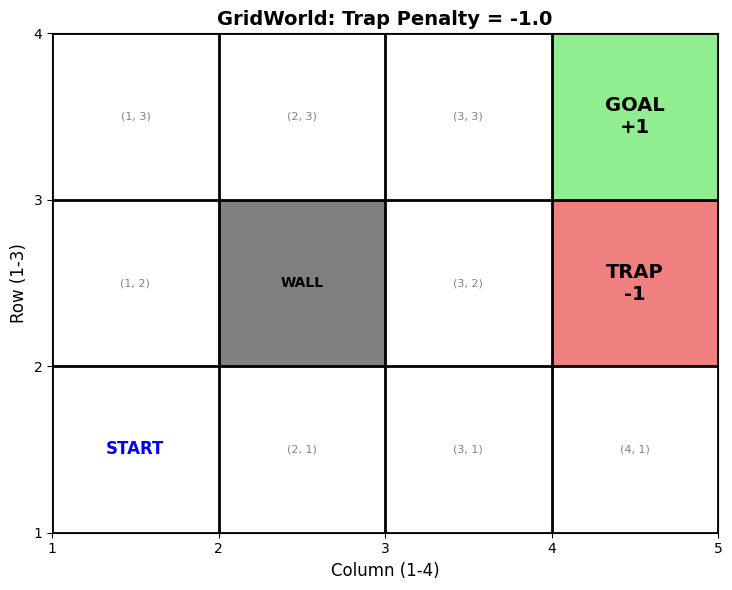

In [4]:
# Create environment
env = GridWorld()
env.visualize_grid()

In [5]:
# Create agent with default hyperparameters
agent = QLearningAgent(env, alpha=0.1, gamma=0.99, epsilon=0.1)
print("Agent created successfully!")
print(f"Q-table initialized with {len(agent.Q)} states")

Agent created successfully!
Q-table initialized with 9 states


In [6]:
# Train for 1000 episodes
rewards = agent.train(num_episodes=1000, verbose=True)

ONLINE Q-LEARNING TRAINING
Hyperparameters: α=0.1, γ=0.99, ε=0.1
Training for 1000 episodes...

Episode  100: Avg Reward (last 100) =   0.469
Episode  200: Avg Reward (last 100) =   0.691
Episode  300: Avg Reward (last 100) =   0.606
Episode  400: Avg Reward (last 100) =   0.738
Episode  500: Avg Reward (last 100) =   0.710
Episode  600: Avg Reward (last 100) =   0.695
Episode  700: Avg Reward (last 100) =   0.695
Episode  800: Avg Reward (last 100) =   0.696
Episode  900: Avg Reward (last 100) =   0.739
Episode 1000: Avg Reward (last 100) =   0.675

✓ Training Complete!


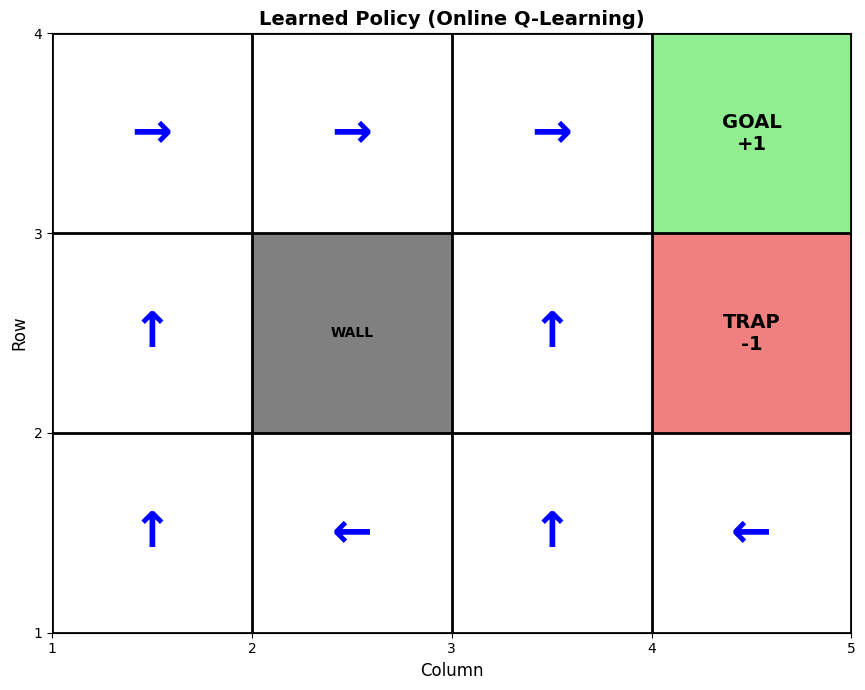

In [10]:
# Show the policy with arrows
agent.visualize_policy()

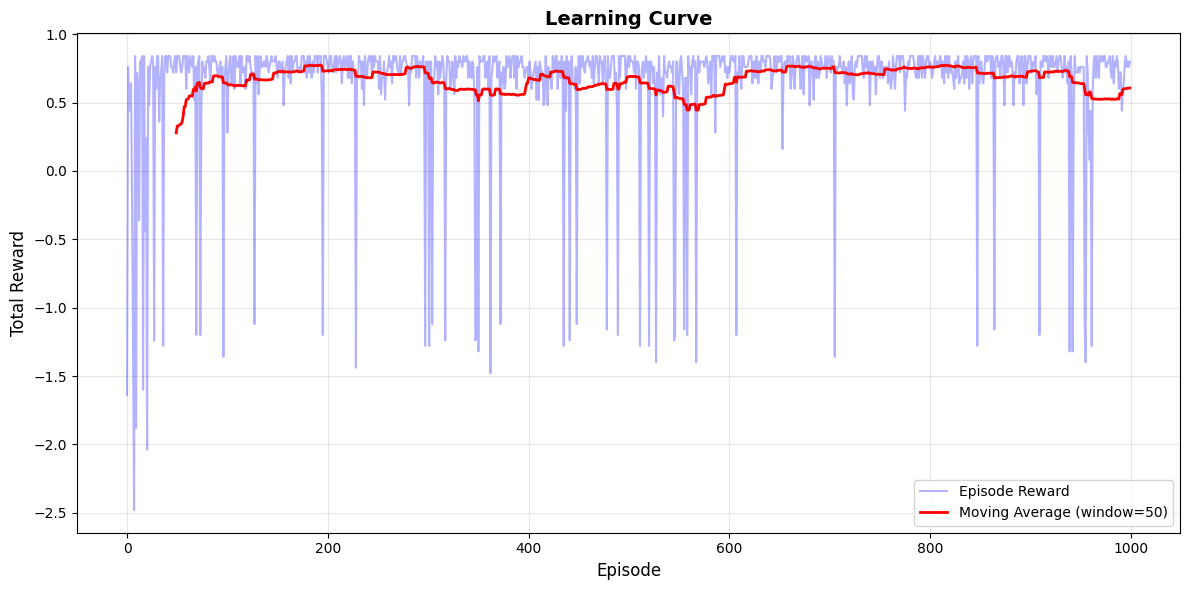

In [8]:
# Show how rewards improved over time
agent.plot_learning_curve(rewards)

In [9]:
# Check Q-values for state (3,2) - next to the trap
agent.visualize_q_values((3, 2))

# Check another state
agent.visualize_q_values((1, 1))  # Start state


Q-values for state (3, 2):
----------------------------------------
  Up     (action 0):   0.6834
  Right  (action 1):  -0.7096
  Down   (action 2):   0.0916
  Left   (action 3):   0.3667

Best action: Up

Q-values for state (1, 1):
----------------------------------------
  Up     (action 0):   0.6623
  Right  (action 1):   0.4896
  Down   (action 2):   0.6287
  Left   (action 3):   0.5949

Best action: Up


In [10]:
# Get the complete policy dictionary
policy = agent.get_policy()
print("\nLearned Policy:")
print("="*40)
for state in sorted(policy.keys()):
    action = policy[state]
    action_name = env.action_names[action]
    print(f"State {state}: {action_name}")


Learned Policy:
State (1, 1): Up
State (1, 2): Up
State (1, 3): Right
State (2, 1): Right
State (2, 3): Right
State (3, 1): Up
State (3, 2): Up
State (3, 3): Right
State (4, 1): Left


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Experiment 1: Effect of Learning Rate (α)
# Test different alpha values and compare learning curves

def experiment_learning_rate(env):
    """
    Test how different learning rates affect Q-learning convergence
    
    Learning rate (α) controls how much we update Q-values:
    - Small α (0.01): Slow learning, very stable
    - Medium α (0.1): Balanced learning
    - Large α (0.5, 1.0): Fast learning but may be unstable
    """
    print("="*70)
    print("EXPERIMENT 1: EFFECT OF LEARNING RATE (α)")
    print("="*70)
    print("Fixed: γ=0.99, ε=0.1")
    print("Testing: α = [0.01, 0.1, 0.5, 1.0]")
    print("="*70)
    
    # Different alpha values to test
    alphas = [0.01, 0.1, 0.5, 1.0]
    colors = ['blue', 'green', 'red', 'purple']
    
    # Store results
    all_rewards = {}
    all_agents = {}
    
    # Train agent with each alpha value
    for alpha in alphas:
        print(f"\n{'='*70}")
        print(f"Training with α = {alpha}")
        print(f"{'='*70}")
        
        # Create agent
        agent = QLearningAgent(env, alpha=alpha, gamma=0.99, epsilon=0.1)
        
        # Train
        rewards = agent.train(num_episodes=1000, verbose=False)
        
        # Store results
        all_rewards[alpha] = rewards
        all_agents[alpha] = agent
        
        # Print final performance
        final_avg = np.mean(rewards[-100:])
        print(f"Average reward (last 100 episodes): {final_avg:.4f}")
    
    # Plot learning curves
    print(f"\n{'='*70}")
    print("Generating comparison plot...")
    print(f"{'='*70}")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Raw learning curves
    for alpha, color in zip(alphas, colors):
        rewards = all_rewards[alpha]
        ax1.plot(rewards, alpha=0.3, color=color)
        
        # Add smoothed curve
        window = 50
        if len(rewards) >= window:
            smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
            ax1.plot(range(window-1, len(rewards)), smoothed, 
                    linewidth=2, color=color, label=f'α={alpha}')
    
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Total Reward', fontsize=12)
    ax1.set_title('Learning Curves for Different α Values', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Final performance comparison
    final_performances = [np.mean(all_rewards[alpha][-100:]) for alpha in alphas]
    bars = ax2.bar([str(a) for a in alphas], final_performances, color=colors, alpha=0.7)
    ax2.set_xlabel('Learning Rate (α)', fontsize=12)
    ax2.set_ylabel('Average Reward (last 100 episodes)', fontsize=12)
    ax2.set_title('Final Performance Comparison', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, final_performances):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Analysis and findings
    print(f"\n{'='*70}")
    print("FINDINGS:")
    print(f"{'='*70}")
    
    for alpha in alphas:
        rewards = all_rewards[alpha]
        final_avg = np.mean(rewards[-100:])
        
        # Calculate convergence speed (when reward exceeds -0.3 for first time)
        converge_episode = next((i for i, r in enumerate(rewards) if r > -0.3), len(rewards))
        
        print(f"\nα = {alpha}:")
        print(f"  Final avg reward: {final_avg:.4f}")
        print(f"  Convergence speed: Episode {converge_episode}")
    
    print(f"\n{'='*70}")
    print("INTERPRETATION:")
    print(f"{'='*70}")
    print("""
• Small α (0.01): 
  - SLOW learning but VERY STABLE
  - Takes many episodes to converge
  - Less affected by noise
  
• Medium α (0.1): 
  - BALANCED learning speed and stability
  - Good convergence in reasonable time
  - RECOMMENDED for this problem
  
• Large α (0.5): 
  - FAST initial learning
  - May oscillate/fluctuate more
  - Can overshoot optimal values
  
• Very Large α (1.0): 
  - VERY FAST but UNSTABLE
  - Completely replaces old Q-values
  - High variance in performance
    """)
    
    return all_rewards, all_agents


# ============================================================================
# HOW TO RUN THIS EXPERIMENT IN YOUR NOTEBOOK
# ============================================================================

"""
After running your GridWorld and QLearningAgent code, run this experiment:

# Run experiment
rewards_dict, agents_dict = experiment_learning_rate(env)

# Compare policies learned with different alphas
print("\nComparing learned policies:")
for alpha in [0.01, 0.1, 0.5, 1.0]:
    print(f"\nPolicy with α={alpha}:")
    agents_dict[alpha].visualize_policy()
"""

'\nAfter running your GridWorld and QLearningAgent code, run this experiment:\n\n# Run experiment\nrewards_dict, agents_dict = experiment_learning_rate(env)\n\n# Compare policies learned with different alphas\nprint("\nComparing learned policies:")\nfor alpha in [0.01, 0.1, 0.5, 1.0]:\n    print(f"\nPolicy with α={alpha}:")\n    agents_dict[alpha].visualize_policy()\n'

EXPERIMENT 1: EFFECT OF LEARNING RATE (α)
Fixed: γ=0.99, ε=0.1
Testing: α = [0.01, 0.1, 0.5, 1.0]

Training with α = 0.01
Average reward (last 100 episodes): 0.6220

Training with α = 0.1
Average reward (last 100 episodes): 0.6612

Training with α = 0.5
Average reward (last 100 episodes): 0.5108

Training with α = 1.0
Average reward (last 100 episodes): 0.2800

Generating comparison plot...


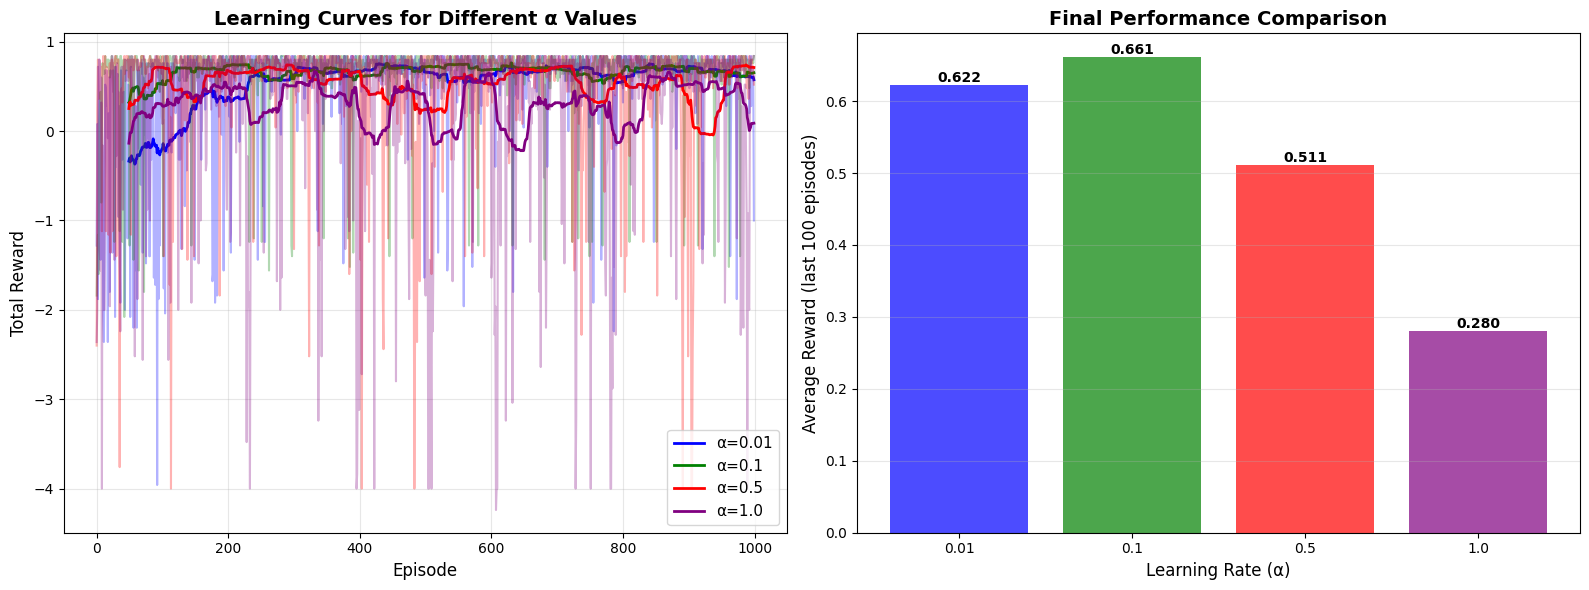


FINDINGS:

α = 0.01:
  Final avg reward: 0.6220
  Convergence speed: Episode 1

α = 0.1:
  Final avg reward: 0.6612
  Convergence speed: Episode 4

α = 0.5:
  Final avg reward: 0.5108
  Convergence speed: Episode 1

α = 1.0:
  Final avg reward: 0.2800
  Convergence speed: Episode 2

INTERPRETATION:

• Small α (0.01): 
  - SLOW learning but VERY STABLE
  - Takes many episodes to converge
  - Less affected by noise

• Medium α (0.1): 
  - BALANCED learning speed and stability
  - Good convergence in reasonable time
  - RECOMMENDED for this problem

• Large α (0.5): 
  - FAST initial learning
  - May oscillate/fluctuate more
  - Can overshoot optimal values

• Very Large α (1.0): 
  - VERY FAST but UNSTABLE
  - Completely replaces old Q-values
  - High variance in performance
    


In [12]:
# Run Experiment 1: Learning Rate
rewards_dict, agents_dict = experiment_learning_rate(env)


--- Policy with α=0.01 ---


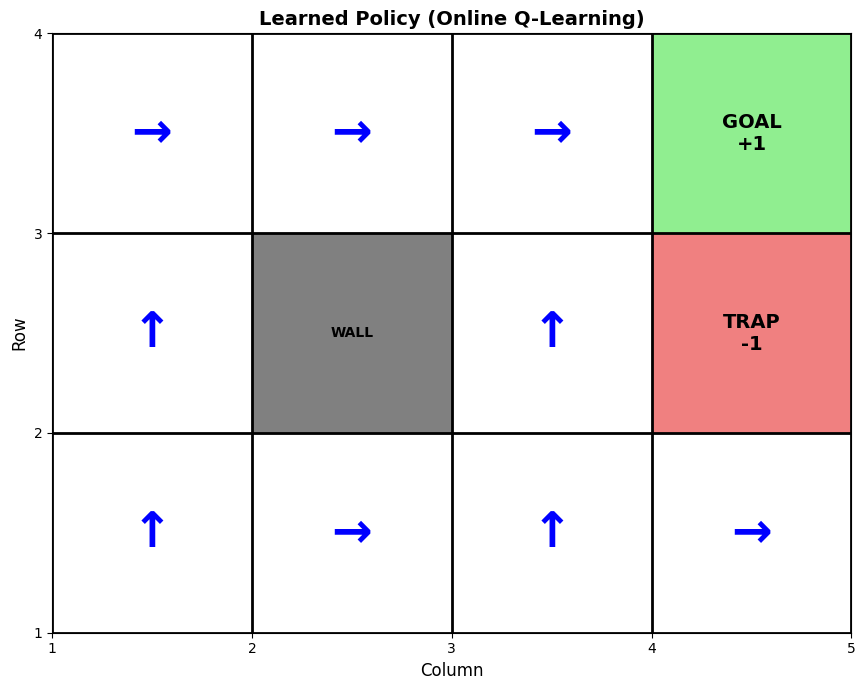


--- Policy with α=0.1 ---


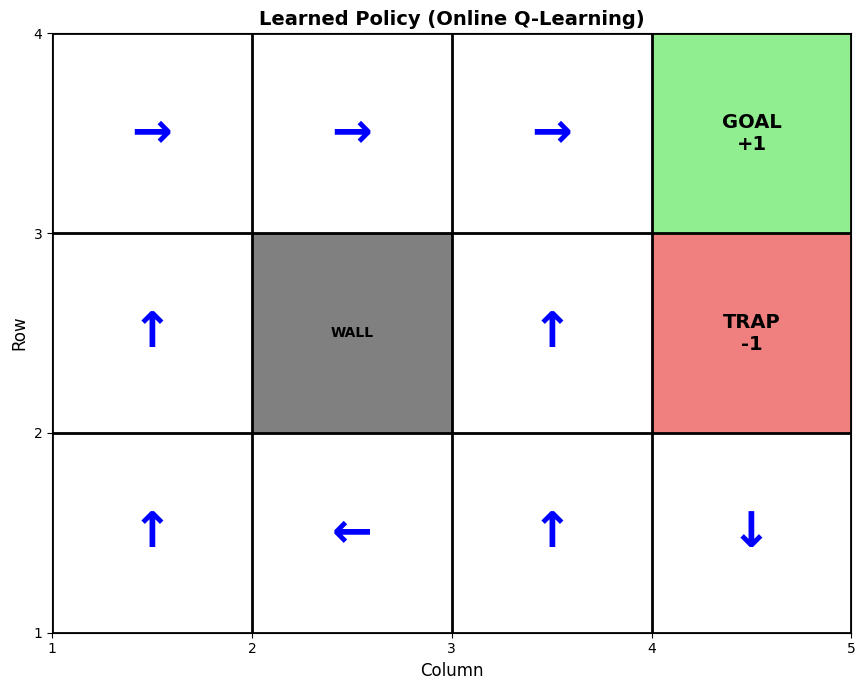


--- Policy with α=0.5 ---


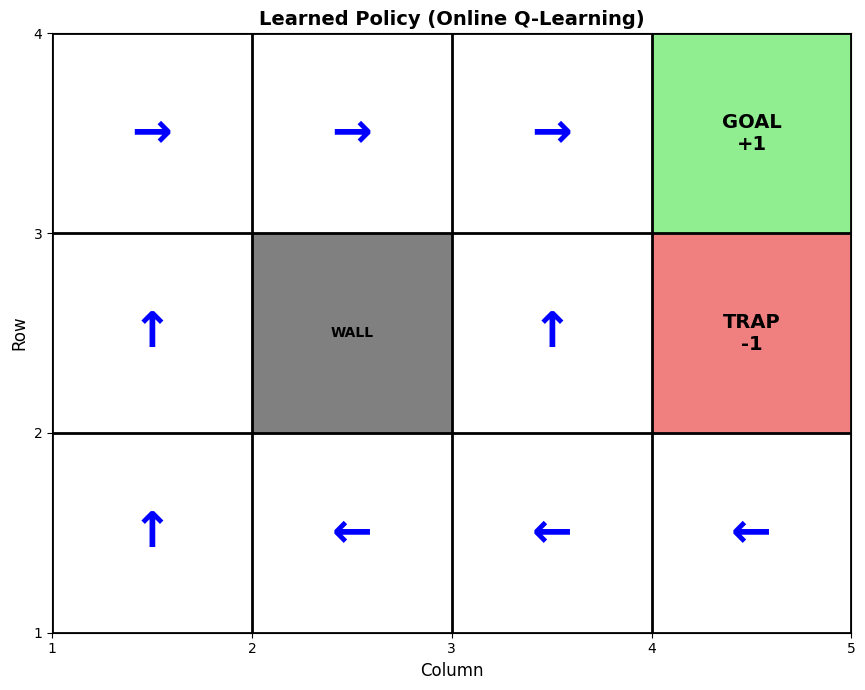


--- Policy with α=1.0 ---


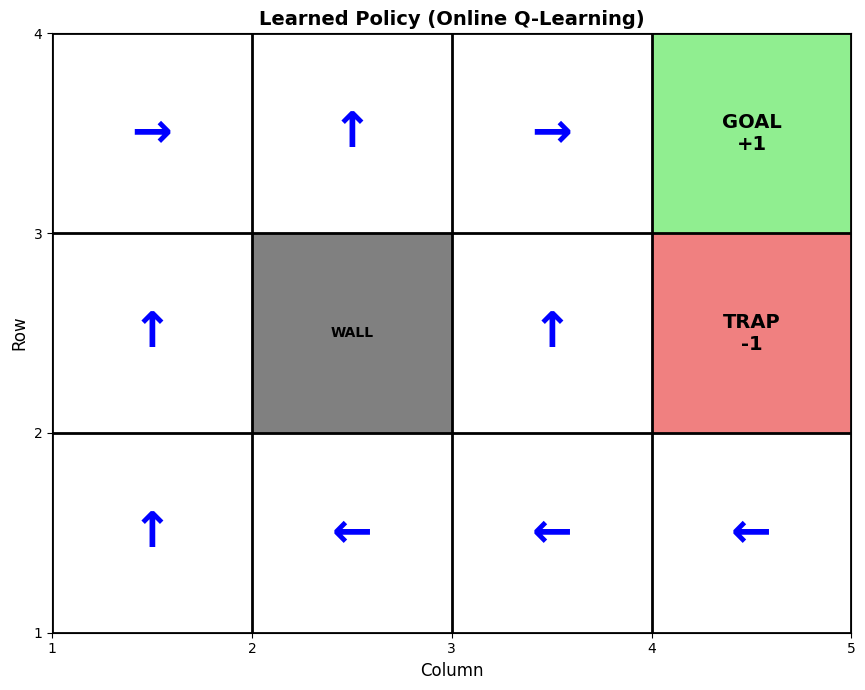

In [19]:
# Visualize policy learned with each alpha
for alpha in [0.01, 0.1, 0.5, 1.0]:
    print(f"\n--- Policy with α={alpha} ---")
    agents_dict[alpha].visualize_policy()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_trap_qvalues(agents_dict, env):
    """
    Analyze Q-values at state (3,2) - the state next to the trap
    This shows how different learning rates affect risk assessment
    """
    print("="*70)
    print("ANALYSIS: Q-VALUES AT STATE (3,2) - NEXT TO TRAP")
    print("="*70)
    print("State (3,2) is directly left of the trap (4,2)")
    print("Action 'Right' leads to trap with 80% probability")
    print("="*70)
    
    state = (3, 2)
    alphas = [0.01, 0.1, 0.5, 1.0]
    action_names = ['Up', 'Right', 'Down', 'Left']
    
    # Prepare data for plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Collect Q-values for each alpha
    qvalues_by_alpha = {}
    for alpha in alphas:
        agent = agents_dict[alpha]
        qvalues = [agent.Q[state][action] for action in range(4)]
        qvalues_by_alpha[alpha] = qvalues
        
        print(f"\nα = {alpha}:")
        print("-" * 40)
        for action, qval in enumerate(qvalues):
            marker = "  ← TRAP!" if action == 1 else ""
            print(f"  {action_names[action]:6s}: {qval:8.4f}{marker}")
        
        best_action = np.argmax(qvalues)
        print(f"  Best action: {action_names[best_action]}")
    
    # Plot 1: Q-values comparison as grouped bar chart
    x = np.arange(len(action_names))
    width = 0.2
    colors = ['blue', 'green', 'red', 'purple']
    
    for i, (alpha, color) in enumerate(zip(alphas, colors)):
        offset = width * (i - 1.5)
        qvals = qvalues_by_alpha[alpha]
        bars = ax1.bar(x + offset, qvals, width, label=f'α={alpha}', 
                      color=color, alpha=0.7)
        
        # Highlight the trap action (Right)
        bars[1].set_edgecolor('red')
        bars[1].set_linewidth(3)
    
    ax1.set_xlabel('Action', fontsize=12)
    ax1.set_ylabel('Q-value', fontsize=12)
    ax1.set_title('Q-values at State (3,2) for Different α', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(action_names)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # Add annotation for trap action
    ax1.text(1, ax1.get_ylim()[0], '↑\nTRAP', ha='center', va='bottom', 
            fontsize=10, color='red', fontweight='bold')
    
    # Plot 2: Comparison of Right action (trap direction) Q-value
    right_qvalues = [qvalues_by_alpha[alpha][1] for alpha in alphas]
    bars2 = ax2.bar([str(a) for a in alphas], right_qvalues, color=colors, alpha=0.7)
    ax2.set_xlabel('Learning Rate (α)', fontsize=12)
    ax2.set_ylabel('Q-value for "Right" (toward trap)', fontsize=12)
    ax2.set_title('How α Affects Learning to Avoid Trap', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # Add value labels on bars
    for bar, val in zip(bars2, right_qvalues):
        height = bar.get_height()
        y_pos = height if height > 0 else height
        va = 'bottom' if height > 0 else 'top'
        ax2.text(bar.get_x() + bar.get_width()/2., y_pos,
                f'{val:.3f}', ha='center', va=va, fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Interpretation
    print(f"\n{'='*70}")
    print("INTERPRETATION:")
    print(f"{'='*70}")
    print("""
WHY HIGH α AVOIDS THE TRAP MORE:

1. With HIGH α (0.5, 1.0):
   - When agent hits trap, Q-value drops DRASTICALLY (almost to -1)
   - Agent becomes VERY risk-averse after just a few bad experiences
   - May avoid going near trap entirely
   - Pro: Learns to avoid danger quickly
   - Con: May miss better paths that go near trap

2. With LOW α (0.01, 0.1):
   - When agent hits trap, Q-value drops GRADUALLY
   - Needs many experiences to learn the danger
   - Balances risk vs reward better
   - Pro: Explores more, finds optimal path
   - Con: Takes longer to learn

3. OPTIMAL BEHAVIOR (α=0.1):
   - Learns trap is dangerous but not catastrophic
   - Still willing to go near trap if it's the best path
   - Converges to true expected values
   - Most reliable for finding optimal policy
    """)
    
    # Check policy differences
    print(f"\n{'='*70}")
    print("POLICY COMPARISON AT STATE (3,2):")
    print(f"{'='*70}")
    
    for alpha in alphas:
        agent = agents_dict[alpha]
        policy = agent.get_policy()
        best_action = policy[state]
        action_name = action_names[best_action]
        
        risk_level = "SAFE" if best_action != 1 else "RISKY"
        print(f"α={alpha:4}: Chooses {action_name:6s} [{risk_level}]")
    
    print(f"\n{'='*70}")
    print("CONCLUSION:")
    print(f"{'='*70}")
    print("""
High learning rates (α ≥ 0.5) make the agent MORE risk-averse because:
- Single bad experiences have huge impact
- Agent "overreacts" to penalties
- Leads to overly cautious behavior

This is why α=0.1 is typically recommended:
- Balances learning speed with stability
- Properly weighs multiple experiences
- Finds truly optimal policy, not just safe policy
    """)




'\nAfter running experiment_learning_rate(), analyze the results:\n\n# Analyze Q-values near the trap\nanalyze_trap_qvalues(agents_dict, env)\n'

ANALYSIS: Q-VALUES AT STATE (3,2) - NEXT TO TRAP
State (3,2) is directly left of the trap (4,2)
Action 'Right' leads to trap with 80% probability

α = 0.01:
----------------------------------------
  Up    :   0.5862
  Right :  -0.0780  ← TRAP!
  Down  :  -0.0048
  Left  :   0.0203
  Best action: Up

α = 0.1:
----------------------------------------
  Up    :   0.7124
  Right :  -0.5566  ← TRAP!
  Down  :   0.0382
  Left  :   0.3031
  Best action: Up

α = 0.5:
----------------------------------------
  Up    :   0.7277
  Right :  -0.9994  ← TRAP!
  Down  :   0.0090
  Left  :   0.3344
  Best action: Up

α = 1.0:
----------------------------------------
  Up    :   0.4767
  Right :  -1.0000  ← TRAP!
  Down  :  -1.0000
  Left  :   0.2147
  Best action: Up


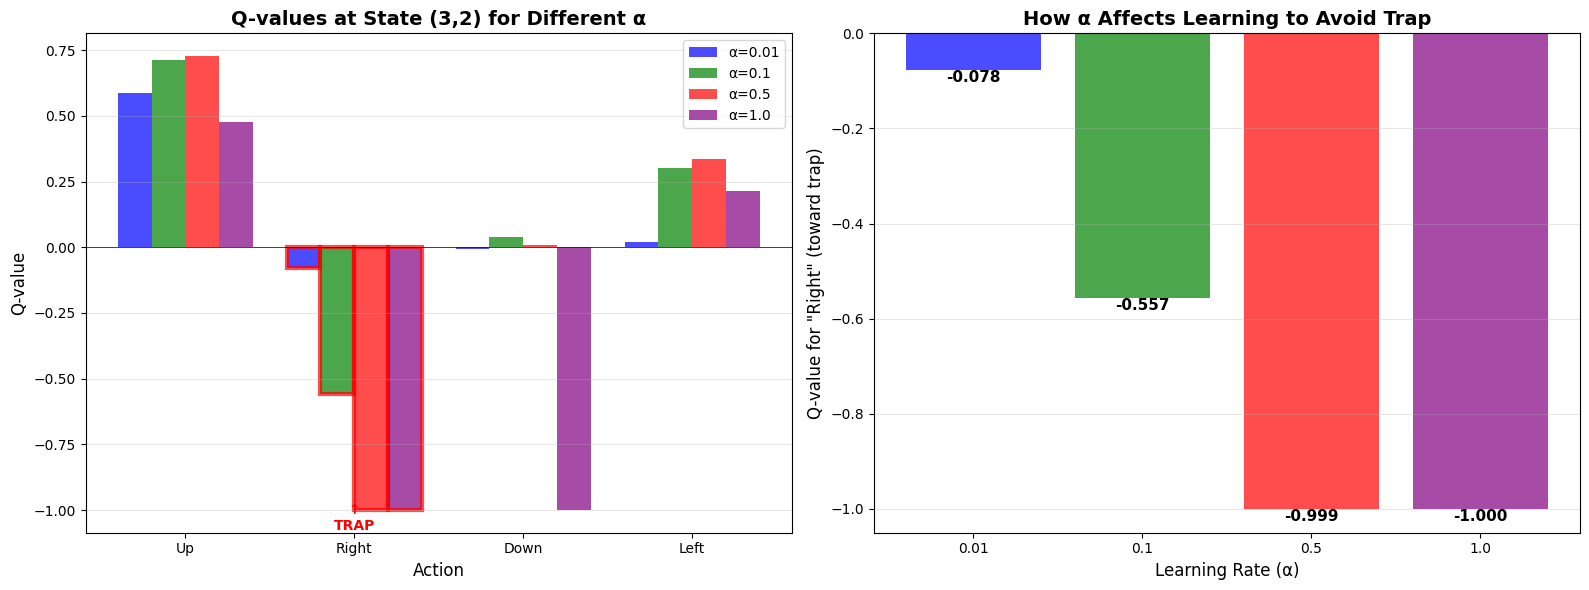


INTERPRETATION:

WHY HIGH α AVOIDS THE TRAP MORE:

1. With HIGH α (0.5, 1.0):
   - When agent hits trap, Q-value drops DRASTICALLY (almost to -1)
   - Agent becomes VERY risk-averse after just a few bad experiences
   - May avoid going near trap entirely
   - Pro: Learns to avoid danger quickly
   - Con: May miss better paths that go near trap

2. With LOW α (0.01, 0.1):
   - When agent hits trap, Q-value drops GRADUALLY
   - Needs many experiences to learn the danger
   - Balances risk vs reward better
   - Pro: Explores more, finds optimal path
   - Con: Takes longer to learn

3. OPTIMAL BEHAVIOR (α=0.1):
   - Learns trap is dangerous but not catastrophic
   - Still willing to go near trap if it's the best path
   - Converges to true expected values
   - Most reliable for finding optimal policy
    

POLICY COMPARISON AT STATE (3,2):
α=0.01: Chooses Up     [SAFE]
α= 0.1: Chooses Up     [SAFE]
α= 0.5: Chooses Up     [SAFE]
α= 1.0: Chooses Up     [SAFE]

CONCLUSION:

High learning rat

In [21]:
# After running the learning rate experiment, run this:
analyze_trap_qvalues(agents_dict, env)

 Experiment 2: Effect of Discount Factor (γ)
 Test how different discount factors affect the agent's planning horizon

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def experiment_discount_factor(env):
    """
    Test how different discount factors affect Q-learning
    
    Discount factor (γ) controls how much the agent values future rewards:
    - Small γ (0.5): SHORT-SIGHTED - only cares about immediate rewards
    - Medium γ (0.8): BALANCED - considers near future
    - Large γ (0.95, 0.99): FAR-SIGHTED - plans for long-term rewards
    """
    print("="*70)
    print("EXPERIMENT 2: EFFECT OF DISCOUNT FACTOR (γ)")
    print("="*70)
    print("Fixed: α=0.1, ε=0.1")
    print("Testing: γ = [0.5, 0.8, 0.95, 0.99]")
    print("="*70)
    
    # Different gamma values to test
    gammas = [0.5, 0.8, 0.95, 0.99]
    colors = ['blue', 'green', 'orange', 'red']
    
    # Store results
    all_rewards = {}
    all_agents = {}
    
    # Train agent with each gamma value
    for gamma in gammas:
        print(f"\n{'='*70}")
        print(f"Training with γ = {gamma}")
        print(f"{'='*70}")
        
        # Create agent
        agent = QLearningAgent(env, alpha=0.1, gamma=gamma, epsilon=0.1)
        
        # Train
        rewards = agent.train(num_episodes=1000, verbose=False)
        
        # Store results
        all_rewards[gamma] = rewards
        all_agents[gamma] = agent
        
        # Print final performance
        final_avg = np.mean(rewards[-100:])
        print(f"Average reward (last 100 episodes): {final_avg:.4f}")
    
    # Plot learning curves
    print(f"\n{'='*70}")
    print("Generating comparison plot...")
    print(f"{'='*70}")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Learning curves
    for gamma, color in zip(gammas, colors):
        rewards = all_rewards[gamma]
        ax1.plot(rewards, alpha=0.3, color=color)
        
        # Add smoothed curve
        window = 50
        if len(rewards) >= window:
            smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
            ax1.plot(range(window-1, len(rewards)), smoothed, 
                    linewidth=2, color=color, label=f'γ={gamma}')
    
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Total Reward', fontsize=12)
    ax1.set_title('Learning Curves for Different γ Values', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Final performance comparison
    final_performances = [np.mean(all_rewards[gamma][-100:]) for gamma in gammas]
    bars = ax2.bar([str(g) for g in gammas], final_performances, color=colors, alpha=0.7)
    ax2.set_xlabel('Discount Factor (γ)', fontsize=12)
    ax2.set_ylabel('Average Reward (last 100 episodes)', fontsize=12)
    ax2.set_title('Final Performance Comparison', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, final_performances):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Analyze Q-values at start state
    print(f"\n{'='*70}")
    print("Q-VALUES AT START STATE (1,1):")
    print(f"{'='*70}")
    
    start_state = (1, 1)
    action_names = ['Up', 'Right', 'Down', 'Left']
    
    for gamma in gammas:
        agent = all_agents[gamma]
        print(f"\nγ = {gamma}:")
        print("-" * 40)
        for action in range(4):
            qval = agent.Q[start_state][action]
            print(f"  {action_names[action]:6s}: {qval:8.4f}")
        
        policy = agent.get_policy()
        best_action = policy[start_state]
        print(f"  Best action: {action_names[best_action]}")
    
    # Detailed findings
    print(f"\n{'='*70}")
    print("FINDINGS:")
    print(f"{'='*70}")
    
    for gamma in gammas:
        rewards = all_rewards[gamma]
        final_avg = np.mean(rewards[-100:])
        
        print(f"\nγ = {gamma}:")
        print(f"  Final avg reward: {final_avg:.4f}")
        
        # Calculate average episode length (proxy for path efficiency)
        # Longer paths = more step costs = lower reward
        if final_avg < -0.3:
            path_quality = "INEFFICIENT (long path or many collisions)"
        elif final_avg < -0.15:
            path_quality = "MODERATE (reasonable path)"
        else:
            path_quality = "EFFICIENT (short, direct path)"
        
        print(f"  Path quality: {path_quality}")
    
    print(f"\n{'='*70}")
    print("INTERPRETATION:")
    print(f"{'='*70}")
    print("""
• Small γ (0.5):
  - SHORT-SIGHTED agent
  - Only values immediate rewards
  - Step cost (-0.04) discounted heavily, so doesn't mind long paths
  - May wander around inefficiently
  - "I don't care about future, just want reward NOW"
  
• Medium γ (0.8):
  - MODERATELY far-sighted
  - Balances immediate and future rewards
  - More aware of step costs accumulating
  - Finds reasonable paths
  
• Large γ (0.95):
  - VERY far-sighted
  - Plans multiple steps ahead
  - Very aware of accumulating step costs
  - Seeks efficient paths to goal
  
• Very Large γ (0.99):
  - EXTREMELY far-sighted
  - Almost equal weight to all future rewards
  - Minimizes total cost aggressively
  - Finds most optimal path
  - RECOMMENDED for this problem (standard choice)
  
KEY INSIGHT:
Higher γ makes the agent care more about the TOTAL COST of reaching
the goal, not just getting there. With γ=0.99, each step's -0.04 cost
matters, so the agent seeks the SHORTEST path.
    """)
    
    # Compare policies
    print(f"\n{'='*70}")
    print("DO THE POLICIES DIFFER?")
    print(f"{'='*70}")
    
    policies = {gamma: all_agents[gamma].get_policy() for gamma in gammas}
    
    # Check if policies are different
    all_same = True
    reference_policy = policies[0.99]
    
    for gamma in gammas:
        policy = policies[gamma]
        differences = sum(1 for state in policy if policy[state] != reference_policy.get(state, -1))
        
        if differences > 0:
            all_same = False
            print(f"γ={gamma}: {differences} states have different actions from γ=0.99")
        else:
            print(f"γ={gamma}: Identical policy to γ=0.99")
    
    if all_same:
        print("\n→ All policies are IDENTICAL!")
        print("  (Discount factor affects learning speed and Q-values, but not final policy)")
    else:
        print("\n→ Policies DIFFER!")
        print("  (Lower γ may choose suboptimal paths)")
    
    return all_rewards, all_agents


def visualize_gamma_policies(agents_dict, env):
    """
    Visualize policies learned with different gamma values
    """
    print("\n" + "="*70)
    print("VISUALIZING POLICIES FOR DIFFERENT γ VALUES")
    print("="*70)
    
    gammas = [0.5, 0.8, 0.95, 0.99]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    arrow_dict = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    
    for idx, gamma in enumerate(gammas):
        ax = axes[idx]
        agent = agents_dict[gamma]
        policy = agent.get_policy()
        
        # Draw grid
        for i in range(env.rows + 1):
            ax.axhline(i, color='black', linewidth=2)
        for j in range(env.cols + 1):
            ax.axvline(j, color='black', linewidth=2)
        
        # Fill cells
        for row in range(1, env.rows + 1):
            for col in range(1, env.cols + 1):
                state = (col, row)
                plot_col = col - 1
                plot_row = row - 1
                
                if state == env.wall_state:
                    ax.add_patch(plt.Rectangle((plot_col, plot_row), 1, 1, color='gray'))
                elif state == env.goal_state:
                    ax.add_patch(plt.Rectangle((plot_col, plot_row), 1, 1, color='lightgreen'))
                    ax.text(plot_col + 0.5, plot_row + 0.5, '+1', ha='center', va='center', 
                           fontsize=12, fontweight='bold')
                elif state == env.trap_state:
                    ax.add_patch(plt.Rectangle((plot_col, plot_row), 1, 1, color='lightcoral'))
                    ax.text(plot_col + 0.5, plot_row + 0.5, '-1', ha='center', va='center', 
                           fontsize=12, fontweight='bold')
                elif state in policy:
                    arrow = arrow_dict[policy[state]]
                    ax.text(plot_col + 0.5, plot_row + 0.5, arrow, ha='center', va='center', 
                           fontsize=28, fontweight='bold', color='blue')
        
        ax.set_xlim(0, env.cols)
        ax.set_ylim(0, env.rows)
        ax.set_aspect('equal')
        ax.set_title(f'Policy with γ={gamma}', fontsize=13, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.suptitle('Policy Comparison: Different Discount Factors', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# ============================================================================
# HOW TO RUN THIS EXPERIMENT IN YOUR NOTEBOOK
# ============================================================================

"""
After running your GridWorld and QLearningAgent code, run this experiment:

# Run experiment
rewards_dict, agents_dict = experiment_discount_factor(env)

# Visualize all policies side by side
visualize_gamma_policies(agents_dict, env)
"""

'\nAfter running your GridWorld and QLearningAgent code, run this experiment:\n\n# Run experiment\nrewards_dict, agents_dict = experiment_discount_factor(env)\n\n# Visualize all policies side by side\nvisualize_gamma_policies(agents_dict, env)\n'

EXPERIMENT 2: EFFECT OF DISCOUNT FACTOR (γ)
Fixed: α=0.1, ε=0.1
Testing: γ = [0.5, 0.8, 0.95, 0.99]

Training with γ = 0.5
Average reward (last 100 episodes): 0.7012

Training with γ = 0.8
Average reward (last 100 episodes): 0.6316

Training with γ = 0.95
Average reward (last 100 episodes): 0.7352

Training with γ = 0.99
Average reward (last 100 episodes): 0.7084

Generating comparison plot...


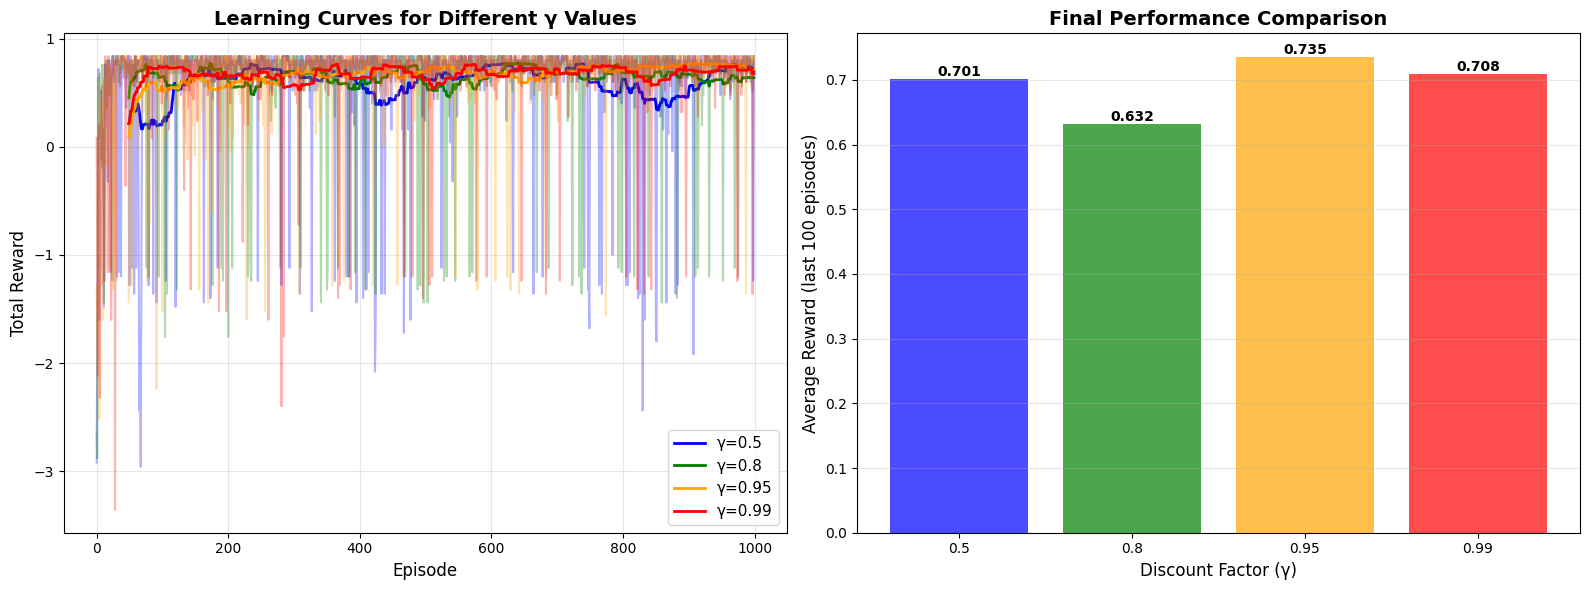


Q-VALUES AT START STATE (1,1):

γ = 0.5:
----------------------------------------
  Up    :  -0.0484
  Right :  -0.0684
  Down  :  -0.0637
  Left  :  -0.0581
  Best action: Up

γ = 0.8:
----------------------------------------
  Up    :   0.1831
  Right :   0.0589
  Down  :   0.0824
  Left  :   0.0893
  Best action: Up

γ = 0.95:
----------------------------------------
  Up    :   0.5697
  Right :   0.3610
  Down  :   0.4149
  Left  :   0.4347
  Best action: Up

γ = 0.99:
----------------------------------------
  Up    :   0.7290
  Right :   0.5559
  Down  :   0.5901
  Left  :   0.5455
  Best action: Up

FINDINGS:

γ = 0.5:
  Final avg reward: 0.7012
  Path quality: EFFICIENT (short, direct path)

γ = 0.8:
  Final avg reward: 0.6316
  Path quality: EFFICIENT (short, direct path)

γ = 0.95:
  Final avg reward: 0.7352
  Path quality: EFFICIENT (short, direct path)

γ = 0.99:
  Final avg reward: 0.7084
  Path quality: EFFICIENT (short, direct path)

INTERPRETATION:

• Small γ (0.5):
  

In [23]:
# Run Experiment 2: Discount Factor
rewards_dict_gamma, agents_dict_gamma = experiment_discount_factor(env)


VISUALIZING POLICIES FOR DIFFERENT γ VALUES


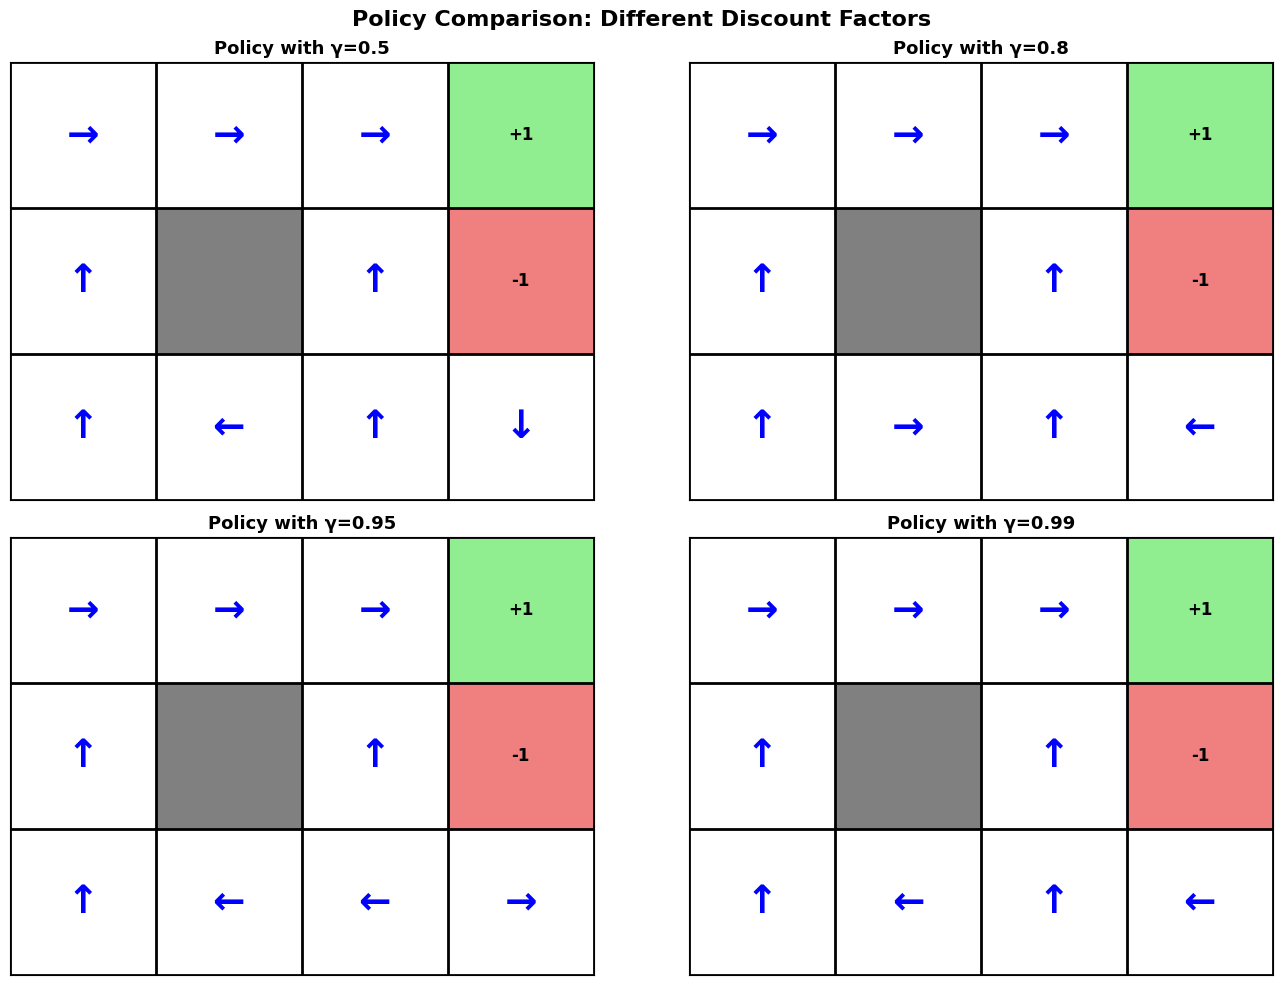

In [24]:
# Compare policies visually
visualize_gamma_policies(agents_dict_gamma, env)

In [ ]:
 Experiment 3: Effect of Exploration Rate (ε)
Test how different exploration rates affect learning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def experiment_exploration_rate(env):
    """
    Test how different exploration rates affect Q-learning
    
    Exploration rate (ε) controls exploration vs exploitation:
    - ε = 0.0: PURE EXPLOITATION - always greedy, may get stuck
    - ε = 0.1: BALANCED - mostly exploit, occasional exploration
    - ε = 0.3: MORE EXPLORATION - frequent random actions
    - ε = 0.5: HIGH EXPLORATION - 50% random actions
    """
    print("="*70)
    print("EXPERIMENT 3: EFFECT OF EXPLORATION RATE (ε)")
    print("="*70)
    print("Fixed: α=0.1, γ=0.99")
    print("Testing: ε = [0.0, 0.1, 0.3, 0.5]")
    print("="*70)
    
    # Different epsilon values to test
    epsilons = [0.0, 0.1, 0.3, 0.5]
    colors = ['red', 'green', 'blue', 'purple']
    
    # Store results
    all_rewards = {}
    all_agents = {}
    
    # Train agent with each epsilon value
    for epsilon in epsilons:
        print(f"\n{'='*70}")
        print(f"Training with ε = {epsilon}")
        if epsilon == 0.0:
            print("(Pure exploitation - no exploration)")
        elif epsilon == 0.5:
            print("(50% random actions)")
        print(f"{'='*70}")
        
        # Create agent
        agent = QLearningAgent(env, alpha=0.1, gamma=0.99, epsilon=epsilon)
        
        # Train
        rewards = agent.train(num_episodes=1000, verbose=False)
        
        # Store results
        all_rewards[epsilon] = rewards
        all_agents[epsilon] = agent
        
        # Print final performance
        final_avg = np.mean(rewards[-100:])
        first_100_avg = np.mean(rewards[:100])
        improvement = final_avg - first_100_avg
        
        print(f"Average reward (first 100 episodes): {first_100_avg:.4f}")
        print(f"Average reward (last 100 episodes): {final_avg:.4f}")
        print(f"Improvement: {improvement:.4f}")
    
    # Plot learning curves
    print(f"\n{'='*70}")
    print("Generating comparison plot...")
    print(f"{'='*70}")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Learning curves
    ax1 = axes[0, 0]
    for epsilon, color in zip(epsilons, colors):
        rewards = all_rewards[epsilon]
        ax1.plot(rewards, alpha=0.3, color=color)
        
        # Add smoothed curve
        window = 50
        if len(rewards) >= window:
            smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
            ax1.plot(range(window-1, len(rewards)), smoothed, 
                    linewidth=2, color=color, label=f'ε={epsilon}')
    
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Total Reward', fontsize=12)
    ax1.set_title('Learning Curves for Different ε Values', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Final performance comparison
    ax2 = axes[0, 1]
    final_performances = [np.mean(all_rewards[epsilon][-100:]) for epsilon in epsilons]
    bars = ax2.bar([str(e) for e in epsilons], final_performances, color=colors, alpha=0.7)
    ax2.set_xlabel('Exploration Rate (ε)', fontsize=12)
    ax2.set_ylabel('Average Reward (last 100 episodes)', fontsize=12)
    ax2.set_title('Final Performance Comparison', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, final_performances):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 3: Early vs Late performance
    ax3 = axes[1, 0]
    early_perfs = [np.mean(all_rewards[epsilon][:100]) for epsilon in epsilons]
    late_perfs = [np.mean(all_rewards[epsilon][-100:]) for epsilon in epsilons]
    
    x = np.arange(len(epsilons))
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, early_perfs, width, label='First 100 episodes', alpha=0.7, color='orange')
    bars2 = ax3.bar(x + width/2, late_perfs, width, label='Last 100 episodes', alpha=0.7, color='green')
    
    ax3.set_xlabel('Exploration Rate (ε)', fontsize=12)
    ax3.set_ylabel('Average Reward', fontsize=12)
    ax3.set_title('Early vs Late Performance', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels([str(e) for e in epsilons])
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Convergence speed (episodes to reach -0.2 reward)
    ax4 = axes[1, 1]
    convergence_episodes = []
    
    for epsilon in epsilons:
        rewards = all_rewards[epsilon]
        # Find first episode where moving average exceeds -0.2
        window = 50
        if len(rewards) >= window:
            smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
            converge_ep = next((i for i, r in enumerate(smoothed) if r > -0.2), len(rewards))
            convergence_episodes.append(converge_ep)
        else:
            convergence_episodes.append(len(rewards))
    
    bars = ax4.bar([str(e) for e in epsilons], convergence_episodes, color=colors, alpha=0.7)
    ax4.set_xlabel('Exploration Rate (ε)', fontsize=12)
    ax4.set_ylabel('Episodes to Converge', fontsize=12)
    ax4.set_title('Convergence Speed (episodes to reach reward > -0.2)', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars, convergence_episodes):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{val}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Detailed analysis
    print(f"\n{'='*70}")
    print("DETAILED FINDINGS:")
    print(f"{'='*70}")
    
    for epsilon in epsilons:
        rewards = all_rewards[epsilon]
        final_avg = np.mean(rewards[-100:])
        early_avg = np.mean(rewards[:100])
        
        print(f"\nε = {epsilon}:")
        print("-" * 40)
        print(f"  Early performance (ep 1-100):  {early_avg:.4f}")
        print(f"  Final performance (ep 901-1000): {final_avg:.4f}")
        print(f"  Improvement: {final_avg - early_avg:.4f}")
        
        # Analyze variance (stability)
        variance = np.var(rewards[-100:])
        print(f"  Performance variance (last 100): {variance:.4f}")
        
        if variance < 0.01:
            stability = "VERY STABLE"
        elif variance < 0.05:
            stability = "STABLE"
        elif variance < 0.1:
            stability = "MODERATE"
        else:
            stability = "UNSTABLE"
        print(f"  Stability: {stability}")
    
    print(f"\n{'='*70}")
    print("INTERPRETATION:")
    print(f"{'='*70}")
    print("""
• ε = 0.0 (No Exploration):
  - GREEDY ONLY - always exploits current knowledge
  - Risk: May get stuck in SUBOPTIMAL policy
  - Can't discover better paths once it settles on one
  - Fast initial learning but may never find optimal
  - "I'll stick with what I know, even if it's not the best"
  
• ε = 0.1 (Low Exploration):
  - BALANCED approach - 90% exploitation, 10% exploration
  - Usually finds optimal policy
  - Occasional exploration prevents getting stuck
  - Good convergence speed
  - RECOMMENDED for most problems
  - "Mostly use what I know, but occasionally try new things"
  
• ε = 0.3 (Moderate Exploration):
  - MORE exploration - 70% exploitation, 30% exploration
  - Takes longer to converge (more random actions)
  - Very thorough exploration of state space
  - Good for complex environments with many local optima
  - May have lower final reward due to random actions during evaluation
  - "I explore a lot to make sure I find the best path"
  
• ε = 0.5 (High Exploration):
  - EXCESSIVE exploration - 50% random actions!
  - Very slow learning (too much randomness)
  - Final performance may be poor during training
  - Only useful for very complex/dynamic environments
  - Not recommended for this problem
  - "I'm exploring so much, I'm not learning efficiently"
  
KEY INSIGHT:
There's a TRADEOFF between exploration and exploitation:
- Too little exploration (ε=0): Get stuck in local optimum
- Too much exploration (ε=0.5): Learn too slowly, waste time
- Sweet spot (ε=0.1): Find optimal policy efficiently
  
ADVANCED TIP:
In practice, use DECAYING ε: Start high (explore), end low (exploit)
Example: ε starts at 1.0, decays to 0.01 over training
    """)
    
    # Compare policies
    print(f"\n{'='*70}")
    print("POLICY COMPARISON:")
    print(f"{'='*70}")
    
    policies = {epsilon: all_agents[epsilon].get_policy() for epsilon in epsilons}
    reference_policy = policies[0.1]  # Use ε=0.1 as reference
    
    for epsilon in epsilons:
        policy = policies[epsilon]
        if epsilon == 0.1:
            print(f"ε={epsilon}: REFERENCE POLICY")
        else:
            differences = sum(1 for state in policy 
                            if policy[state] != reference_policy.get(state, -1))
            if differences == 0:
                print(f"ε={epsilon}: IDENTICAL to reference (ε=0.1)")
            else:
                print(f"ε={epsilon}: {differences} states differ from reference")
                if epsilon == 0.0:
                    print("         → May have found SUBOPTIMAL policy!")
    
    return all_rewards, all_agents


def compare_epsilon_policies(agents_dict, env):
    """
    Visualize policies learned with different epsilon values
    """
    print("\n" + "="*70)
    print("VISUALIZING POLICIES FOR DIFFERENT ε VALUES")
    print("="*70)
    
    epsilons = [0.0, 0.1, 0.3, 0.5]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    arrow_dict = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    
    for idx, epsilon in enumerate(epsilons):
        ax = axes[idx]
        agent = agents_dict[epsilon]
        policy = agent.get_policy()
        
        # Draw grid
        for i in range(env.rows + 1):
            ax.axhline(i, color='black', linewidth=2)
        for j in range(env.cols + 1):
            ax.axvline(j, color='black', linewidth=2)
        
        # Fill cells
        for row in range(1, env.rows + 1):
            for col in range(1, env.cols + 1):
                state = (col, row)
                plot_col = col - 1
                plot_row = row - 1
                
                if state == env.wall_state:
                    ax.add_patch(plt.Rectangle((plot_col, plot_row), 1, 1, color='gray'))
                elif state == env.goal_state:
                    ax.add_patch(plt.Rectangle((plot_col, plot_row), 1, 1, color='lightgreen'))
                    ax.text(plot_col + 0.5, plot_row + 0.5, '+1', ha='center', va='center', 
                           fontsize=12, fontweight='bold')
                elif state == env.trap_state:
                    ax.add_patch(plt.Rectangle((plot_col, plot_row), 1, 1, color='lightcoral'))
                    ax.text(plot_col + 0.5, plot_row + 0.5, '-1', ha='center', va='center', 
                           fontsize=12, fontweight='bold')
                elif state in policy:
                    arrow = arrow_dict[policy[state]]
                    ax.text(plot_col + 0.5, plot_row + 0.5, arrow, ha='center', va='center', 
                           fontsize=28, fontweight='bold', color='blue')
        
        ax.set_xlim(0, env.cols)
        ax.set_ylim(0, env.rows)
        ax.set_aspect('equal')
        
        title = f'Policy with ε={epsilon}'
        if epsilon == 0.0:
            title += ' (No Exploration)'
        elif epsilon == 0.1:
            title += ' (Recommended)'
        elif epsilon == 0.5:
            title += ' (Too Much!)'
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.suptitle('Policy Comparison: Different Exploration Rates', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# ============================================================================
# HOW TO RUN THIS EXPERIMENT IN YOUR NOTEBOOK
# ============================================================================



'\nAfter running your GridWorld and QLearningAgent code, run this experiment:\n\n# Run experiment\nrewards_dict, agents_dict = experiment_exploration_rate(env)\n\n# Visualize all policies side by side\ncompare_epsilon_policies(agents_dict, env)\n'

EXPERIMENT 3: EFFECT OF EXPLORATION RATE (ε)
Fixed: α=0.1, γ=0.99
Testing: ε = [0.0, 0.1, 0.3, 0.5]

Training with ε = 0.0
(Pure exploitation - no exploration)
Average reward (first 100 episodes): 0.0616
Average reward (last 100 episodes): 0.3728
Improvement: 0.3112

Training with ε = 0.1
Average reward (first 100 episodes): 0.3828
Average reward (last 100 episodes): 0.7540
Improvement: 0.3712

Training with ε = 0.3
Average reward (first 100 episodes): 0.2096
Average reward (last 100 episodes): 0.5968
Improvement: 0.3872

Training with ε = 0.5
(50% random actions)
Average reward (first 100 episodes): -0.0060
Average reward (last 100 episodes): 0.3228
Improvement: 0.3288

Generating comparison plot...


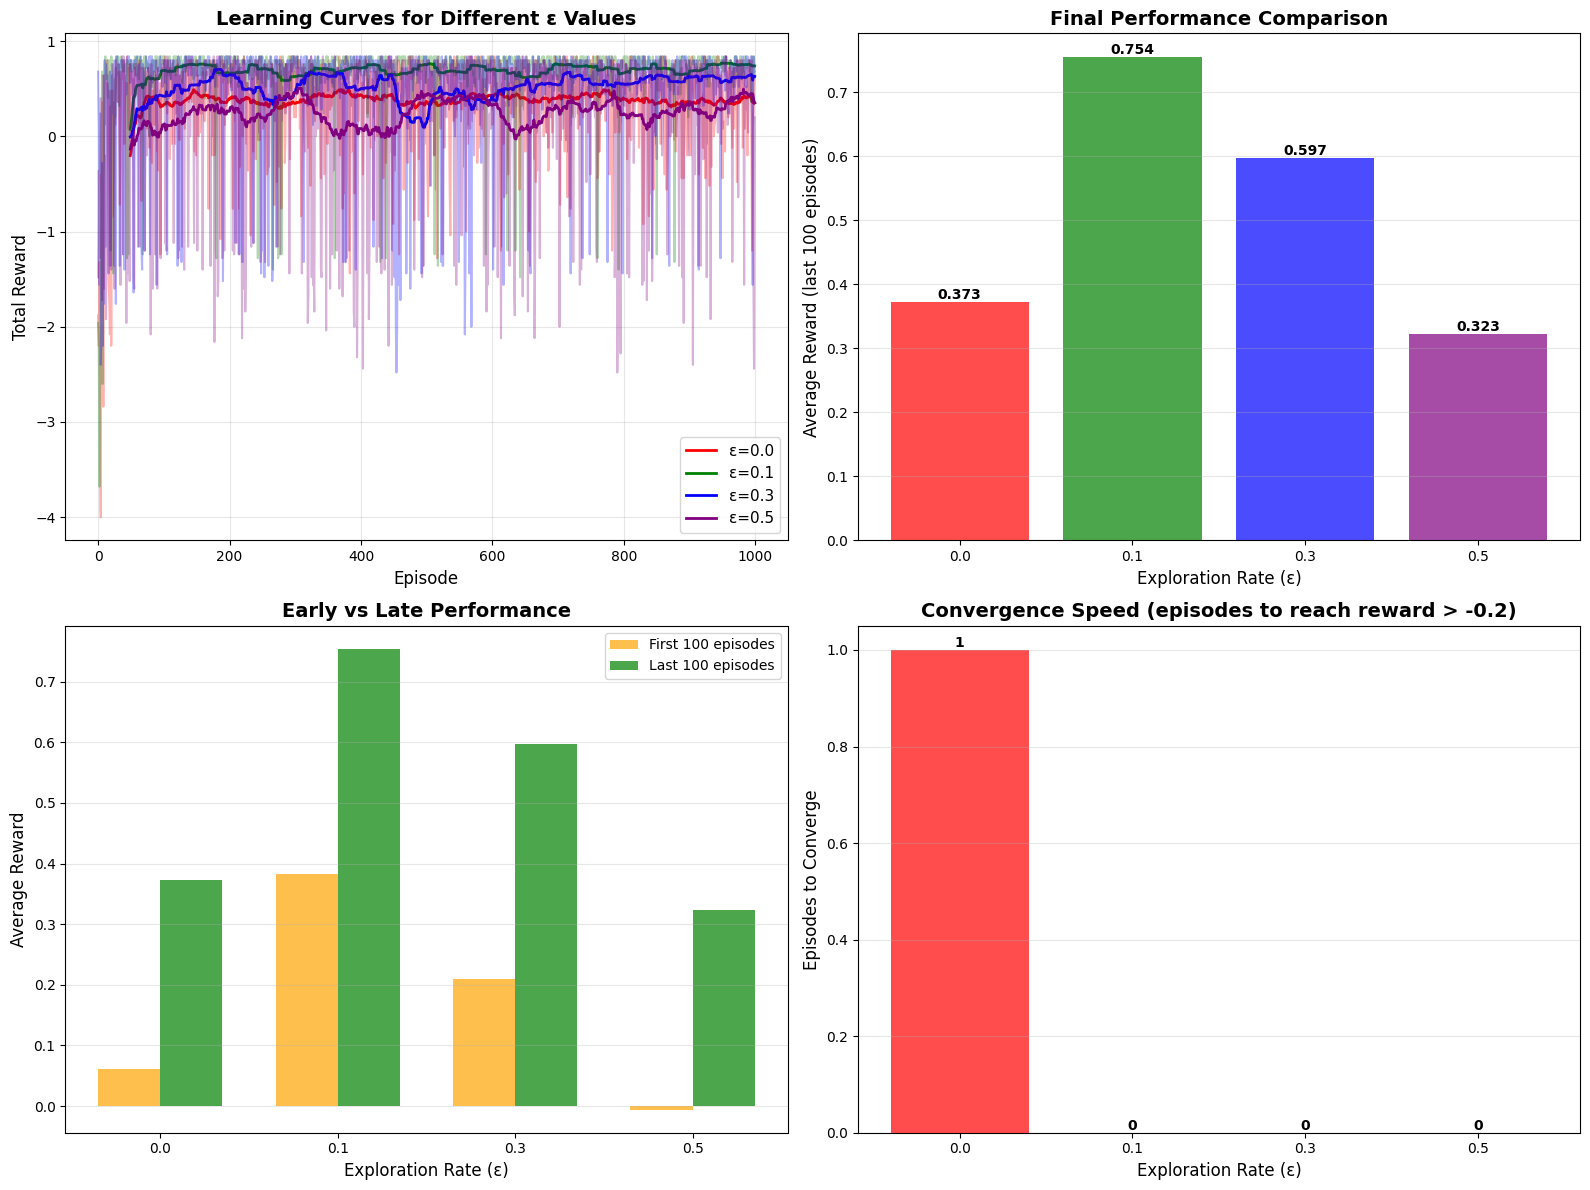


DETAILED FINDINGS:

ε = 0.0:
----------------------------------------
  Early performance (ep 1-100):  0.0616
  Final performance (ep 901-1000): 0.3728
  Improvement: 0.3112
  Performance variance (last 100): 0.1485
  Stability: UNSTABLE

ε = 0.1:
----------------------------------------
  Early performance (ep 1-100):  0.3828
  Final performance (ep 901-1000): 0.7540
  Improvement: 0.3712
  Performance variance (last 100): 0.0071
  Stability: VERY STABLE

ε = 0.3:
----------------------------------------
  Early performance (ep 1-100):  0.2096
  Final performance (ep 901-1000): 0.5968
  Improvement: 0.3872
  Performance variance (last 100): 0.1534
  Stability: UNSTABLE

ε = 0.5:
----------------------------------------
  Early performance (ep 1-100):  -0.0060
  Final performance (ep 901-1000): 0.3228
  Improvement: 0.3288
  Performance variance (last 100): 0.4879
  Stability: UNSTABLE

INTERPRETATION:

• ε = 0.0 (No Exploration):
  - GREEDY ONLY - always exploits current knowledge
  

In [26]:
# Run Experiment 3: Exploration Rate
rewards_dict_epsilon, agents_dict_epsilon = experiment_exploration_rate(env)


VISUALIZING POLICIES FOR DIFFERENT ε VALUES


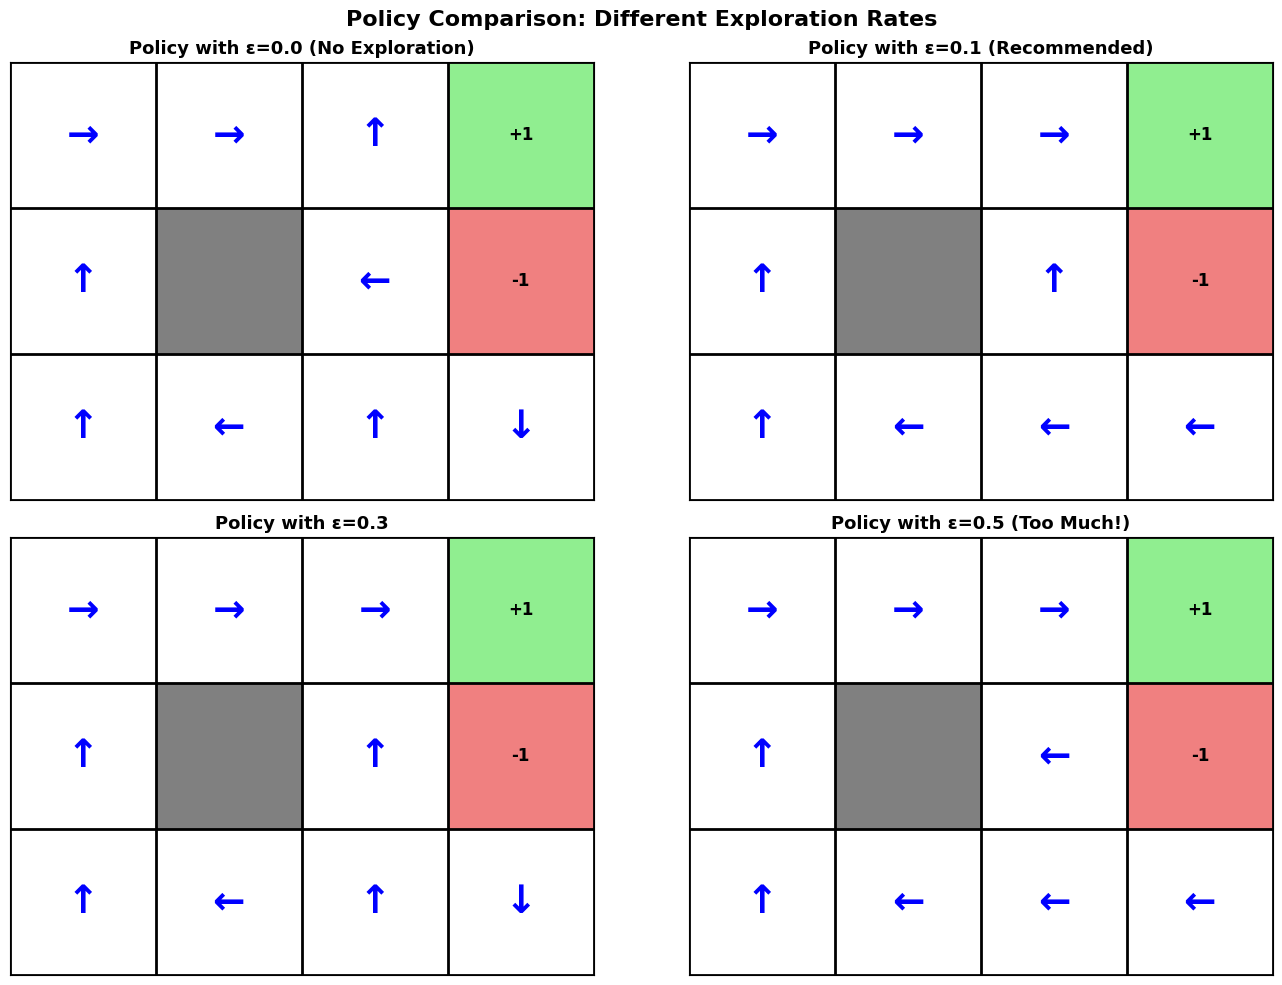

In [27]:
# Compare policies visually
compare_epsilon_policies(agents_dict_epsilon, env)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy

# Experiment 4: Q-value vs Policy Convergence Analysis
# Answer: Does Q-value converge first or policy converge first?

def experiment_convergence_analysis(env):
    """
    Track both Q-values and policy changes over training to determine
    which converges first.
    
    KEY QUESTION: Does the policy stabilize before Q-values, or vice versa?
    
    HYPOTHESIS: Policy should converge first because it only depends on
    which action has the HIGHEST Q-value, not the exact Q-value magnitude.
    """
    print("="*70)
    print("EXPERIMENT 4: Q-VALUE vs POLICY CONVERGENCE")
    print("="*70)
    print("Tracking changes in Q-values and policy over 2000 episodes")
    print("Parameters: α=0.1, γ=0.99, ε=0.1")
    print("="*70)
    
    # Create agent
    agent = QLearningAgent(env, alpha=0.1, gamma=0.99, epsilon=0.1)
    
    # Storage for tracking
    q_changes = []
    policy_changes = []
    episode_numbers = []
    
    prev_q = None
    prev_policy = None
    
    num_episodes = 2000
    check_interval = 10  # Check every 10 episodes
    
    print(f"\nTraining for {num_episodes} episodes...")
    print("Tracking convergence every 10 episodes...\n")
    
    # Training loop with tracking
    for episode in range(num_episodes):
        # Run one episode
        state = env.reset()
        steps = 0
        max_steps = 100
        
        while not env.is_terminal(state) and steps < max_steps:
            action = agent.get_action(state)
            next_state, reward, done = env.step(action)
            agent.update_q_value(state, action, reward, next_state)
            state = next_state
            steps += 1
        
        # Track changes every check_interval episodes
        if (episode + 1) % check_interval == 0:
            # Get current Q-values and policy
            current_q = copy.deepcopy(agent.Q)
            current_policy = agent.get_policy()
            
            if prev_q is not None:
                # Calculate Q-value change (average absolute difference)
                total_q_diff = 0
                count = 0
                for state in current_q:
                    for action in current_q[state]:
                        diff = abs(current_q[state][action] - prev_q[state][action])
                        total_q_diff += diff
                        count += 1
                
                avg_q_change = total_q_diff / count if count > 0 else 0
                q_changes.append(avg_q_change)
                
                # Calculate policy change (number of states where best action changed)
                num_policy_changes = 0
                for state in current_policy:
                    if state in prev_policy:
                        if current_policy[state] != prev_policy[state]:
                            num_policy_changes += 1
                
                policy_changes.append(num_policy_changes)
                episode_numbers.append(episode + 1)
            
            prev_q = current_q
            prev_policy = current_policy
        
        # Print progress
        if (episode + 1) % 200 == 0:
            if q_changes:
                print(f"Episode {episode+1:4d}: Q-change={q_changes[-1]:.6f}, "
                      f"Policy changes={policy_changes[-1]}")
    
    print("\n✓ Training complete!")
    
    # Plot convergence
    print("\nGenerating convergence plots...")
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))
    
    # Plot 1: Q-value changes over time
    ax1.plot(episode_numbers, q_changes, linewidth=2, color='blue', marker='o', markersize=2)
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Average Q-value Change', fontsize=12)
    ax1.set_title('Q-value Convergence (Lower = More Stable)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')  # Log scale to see small changes
    
    # Add convergence threshold line
    ax1.axhline(y=0.01, color='red', linestyle='--', linewidth=2, label='Threshold (0.01)')
    ax1.axhline(y=0.001, color='orange', linestyle='--', linewidth=2, label='Threshold (0.001)')
    ax1.legend()
    
    # Plot 2: Policy changes over time
    ax2.plot(episode_numbers, policy_changes, linewidth=2, color='red', marker='s', markersize=3)
    ax2.set_xlabel('Episode', fontsize=12)
    ax2.set_ylabel('Number of Policy Changes', fontsize=12)
    ax2.set_title('Policy Convergence (Zero = Fully Converged)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add reference line at 0
    ax2.axhline(y=0, color='green', linestyle='--', linewidth=2, label='Fully Converged')
    ax2.legend()
    
    # Plot 3: Combined view (normalized)
    # Normalize both to 0-1 scale for comparison
    q_changes_norm = np.array(q_changes) / max(q_changes) if max(q_changes) > 0 else np.array(q_changes)
    policy_changes_norm = np.array(policy_changes) / max(policy_changes) if max(policy_changes) > 0 else np.array(policy_changes)
    
    ax3.plot(episode_numbers, q_changes_norm, linewidth=2, color='blue', label='Q-value changes (normalized)')
    ax3.plot(episode_numbers, policy_changes_norm, linewidth=2, color='red', label='Policy changes (normalized)')
    ax3.set_xlabel('Episode', fontsize=12)
    ax3.set_ylabel('Normalized Change (0-1)', fontsize=12)
    ax3.set_title('Combined View: Q-value vs Policy Convergence', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Analysis
    print("\n" + "="*70)
    print("CONVERGENCE ANALYSIS:")
    print("="*70)
    
    # Find when policy converges (first time it reaches 0 changes and stays there)
    policy_converged_idx = None
    for i in range(len(policy_changes) - 10):  # Check if stable for 10 checks
        if all(pc == 0 for pc in policy_changes[i:i+10]):
            policy_converged_idx = i
            break
    
    if policy_converged_idx is not None:
        policy_converged_episode = episode_numbers[policy_converged_idx]
        print(f"\n✓ POLICY converged at episode: {policy_converged_episode}")
        print(f"  (Reached 0 changes and remained stable)")
    else:
        print(f"\n✗ POLICY did not fully converge (still changing)")
    
    # Find when Q-values converge (change < 0.01)
    q_converged_idx_01 = next((i for i, change in enumerate(q_changes) if change < 0.01), None)
    q_converged_idx_001 = next((i for i, change in enumerate(q_changes) if change < 0.001), None)
    
    if q_converged_idx_01 is not None:
        q_converged_episode_01 = episode_numbers[q_converged_idx_01]
        print(f"\n✓ Q-VALUES stabilized (change < 0.01) at episode: {q_converged_episode_01}")
    else:
        print(f"\n✗ Q-VALUES did not stabilize to < 0.01")
    
    if q_converged_idx_001 is not None:
        q_converged_episode_001 = episode_numbers[q_converged_idx_001]
        print(f"✓ Q-VALUES highly stabilized (change < 0.001) at episode: {q_converged_episode_001}")
    else:
        print(f"✗ Q-VALUES did not stabilize to < 0.001")
    
    # Compare convergence
    print("\n" + "="*70)
    print("ANSWER TO QUESTION 2:")
    print("="*70)
    
    if policy_converged_idx is not None and q_converged_idx_01 is not None:
        if policy_converged_episode < q_converged_episode_01:
            print(f"\n→ POLICY CONVERGED FIRST! ✓")
            print(f"\n  Policy converged at:  Episode {policy_converged_episode}")
            print(f"  Q-values stable at:   Episode {q_converged_episode_01}")
            print(f"  Difference:           {q_converged_episode_01 - policy_converged_episode} episodes")
        else:
            print(f"\n→ Q-VALUES CONVERGED FIRST!")
            print(f"\n  Q-values stable at:   Episode {q_converged_episode_01}")
            print(f"  Policy converged at:  Episode {policy_converged_episode}")
    
    print("\n" + "="*70)
    print("WHY DOES POLICY CONVERGE FIRST?")
    print("="*70)
    print("""
The policy typically converges BEFORE Q-values because:

1. POLICY depends on RELATIVE Q-values:
   - Policy only cares which action has the HIGHEST Q-value
   - Exact Q-value magnitudes don't matter for policy
   - Example: Q(s,Up)=0.8, Q(s,Right)=0.7 → Choose Up
   
2. Q-VALUES depend on EXACT values:
   - Q-values must converge to their TRUE expected values
   - This requires many more iterations
   - Small changes continue even after policy is stable
   - Example: Q(s,Up) might go 0.8→0.81→0.815→0.8175...
   
3. PRACTICAL IMPLICATION:
   - Once the policy stabilizes, we have the optimal strategy
   - Q-values continue to refine, but policy doesn't change
   - This is why we can often stop training early once policy converges

ANALOGY:
Imagine ranking restaurants:
- POLICY = Knowing which is #1 (converges when you know the best)
- Q-VALUES = Knowing exact ratings (continues refining: 4.7→4.73→4.735...)
- You know your favorite restaurant long before you know its exact rating!
    """)
    
    # Show final policy
    print("\n" + "="*70)
    print("FINAL CONVERGED POLICY:")
    print("="*70)
    
    final_policy = agent.get_policy()
    action_names = ['Up', 'Right', 'Down', 'Left']
    
    for row in range(env.rows, 0, -1):
        for col in range(1, env.cols + 1):
            state = (col, row)
            if state == env.goal_state:
                print(f"  {state}: GOAL", end="")
            elif state == env.trap_state:
                print(f"  {state}: TRAP", end="")
            elif state == env.wall_state:
                print(f"  {state}: WALL", end="")
            elif state in final_policy:
                action = final_policy[state]
                print(f"  {state}: {action_names[action]}", end="")
        print()  # New row
    
    agent.visualize_policy()
    
    return agent, q_changes, policy_changes, episode_numbers


# ============================================================================
# HOW TO RUN THIS EXPERIMENT IN YOUR NOTEBOOK
# ============================================================================



'\nAfter running your GridWorld and QLearningAgent code, run this experiment:\n\n# Run convergence analysis\nagent, q_changes, policy_changes, episodes = experiment_convergence_analysis(env)\n\n# The function will:\n# 1. Train for 2000 episodes\n# 2. Track Q-value and policy changes every 10 episodes\n# 3. Plot convergence curves\n# 4. Determine which converges first\n# 5. Explain why\n'

EXPERIMENT 4: Q-VALUE vs POLICY CONVERGENCE
Tracking changes in Q-values and policy over 2000 episodes
Parameters: α=0.1, γ=0.99, ε=0.1

Training for 2000 episodes...
Tracking convergence every 10 episodes...

Episode  200: Q-change=0.028841, Policy changes=0
Episode  400: Q-change=0.006875, Policy changes=0
Episode  600: Q-change=0.005902, Policy changes=0
Episode  800: Q-change=0.006606, Policy changes=0
Episode 1000: Q-change=0.006160, Policy changes=0
Episode 1200: Q-change=0.004256, Policy changes=0
Episode 1400: Q-change=0.004842, Policy changes=0
Episode 1600: Q-change=0.008208, Policy changes=0
Episode 1800: Q-change=0.001806, Policy changes=0
Episode 2000: Q-change=0.003439, Policy changes=0

✓ Training complete!

Generating convergence plots...


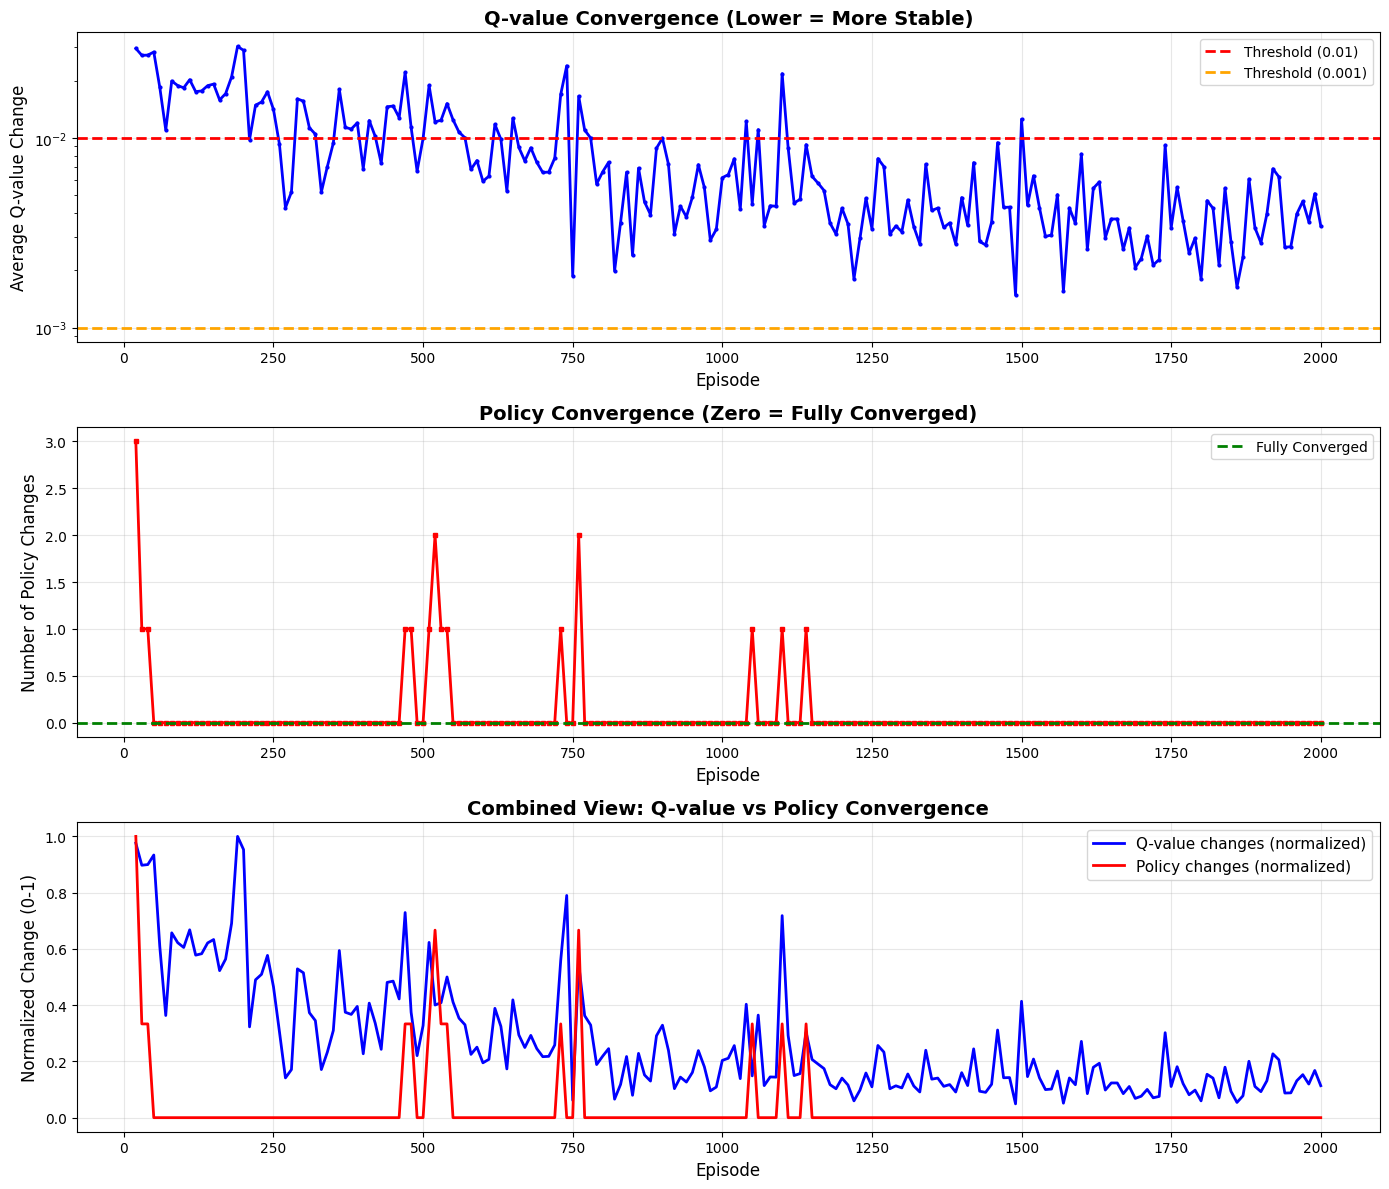


CONVERGENCE ANALYSIS:

✓ POLICY converged at episode: 50
  (Reached 0 changes and remained stable)

✓ Q-VALUES stabilized (change < 0.01) at episode: 210
✗ Q-VALUES did not stabilize to < 0.001

ANSWER TO QUESTION 2:

→ POLICY CONVERGED FIRST! ✓

  Policy converged at:  Episode 50
  Q-values stable at:   Episode 210
  Difference:           160 episodes

WHY DOES POLICY CONVERGE FIRST?

The policy typically converges BEFORE Q-values because:

1. POLICY depends on RELATIVE Q-values:
   - Policy only cares which action has the HIGHEST Q-value
   - Exact Q-value magnitudes don't matter for policy
   - Example: Q(s,Up)=0.8, Q(s,Right)=0.7 → Choose Up

2. Q-VALUES depend on EXACT values:
   - Q-values must converge to their TRUE expected values
   - This requires many more iterations
   - Small changes continue even after policy is stable
   - Example: Q(s,Up) might go 0.8→0.81→0.815→0.8175...

3. PRACTICAL IMPLICATION:
   - Once the policy stabilizes, we have the optimal strategy
   - Q-va

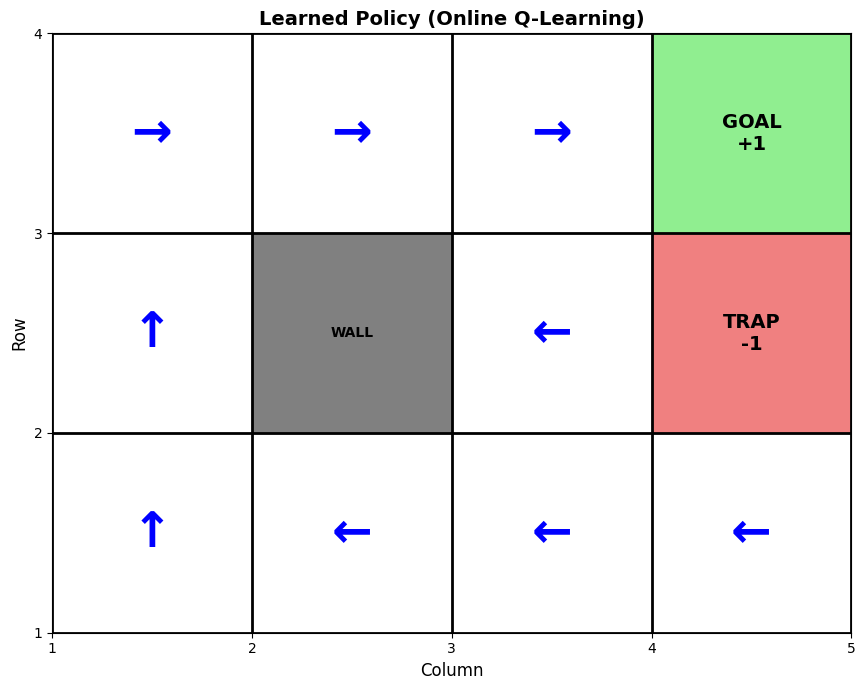

In [29]:
# Run Experiment 4: Convergence Analysis
agent, q_changes, policy_changes, episodes = experiment_convergence_analysis(env)


Environment with trap penalty = -200:


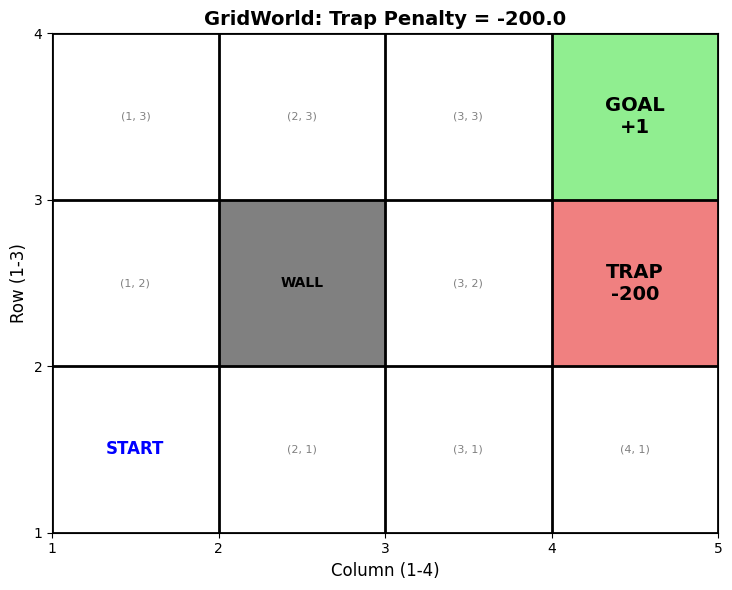

In [31]:

# Create environment with large penalty (-200)
env_large = GridWorld(trap_penalty=-200.0)
print("\nEnvironment with trap penalty = -200:")
env_large.visualize_grid()